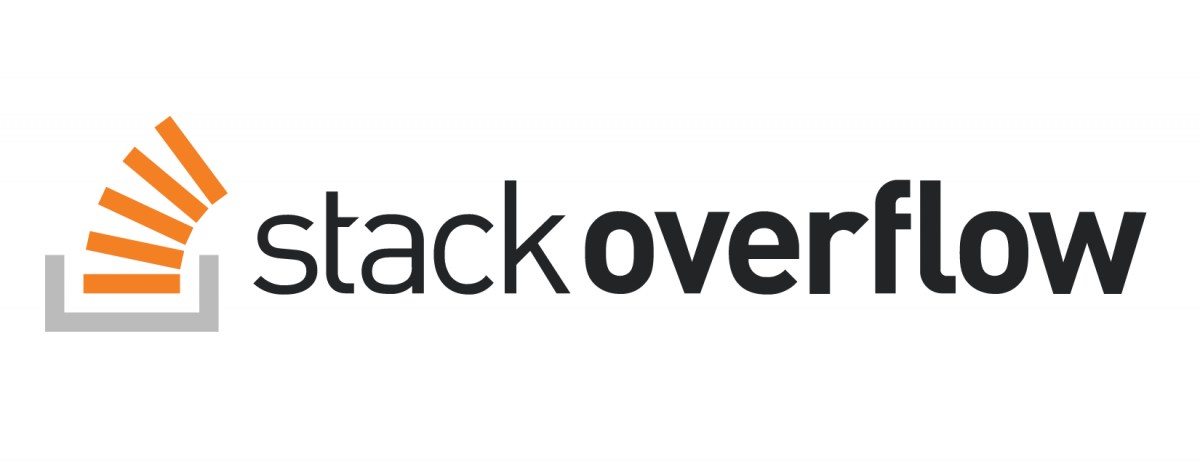

# <font color="#1d479b">Contexte</font>

Développer un système de suggestion de tag pour les questions.

Sur le Notebook 1:
- Cleaning
    - méthodes d'extraction de features
    - méthodes réduction dimensionnelle
    
- Exploration analyse univariée, analyse multivariée

Sur le Notebook 2 :
- Utiliser une approche **supervisée** ou non pour extraire des tags à partir des résultats précédents.
- Mettre en œuvre une approche **non supervisée**.
- Comparer ses résultats à une approche purement **supervisée**



## <font color="#337da4">Récupération de la donnée</font>

In [3]:
import numpy as np
import matplotlib as plt
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

--------------------------
 Récuperation de la donnée
-------------------------
Critères de filtre :

- ` AnswerCount`  > 10
- ` FavoriteCount`  > 200
- ` ViewCount`  > 5000  vues
- ` Score`  > 15


### post_df

In [2]:
post_df= pd.read_csv("Posts.csv")
print(post_df.shape)

df1 = post_df.dropna(subset=['Title', 'Tags'])
print(df1.shape)
df1.head(2) #max50000

(50000, 23)
(9733, 23)


,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,4,1,7.0,NaN,2008-07-31 21:42:52,NaN,735,59417.0,<p>I want to use a <code>Track-Bar</code> to c...,8.0,NaN,3072350.0,Rich B,2021-02-26 03:31:15,2021-02-26 03:31:15,How to convert a Decimal to a Double in C#?,<c#><floating-point><type-conversion><double><...,14.0,5,57.0,NaN,2012-10-31 16:42:47,CC BY-SA 4.0
1,6,1,31.0,NaN,2008-07-31 22:08:08,NaN,308,21790.0,<p>I have an absolutely positioned <code>div</...,9.0,NaN,9134576.0,user14723686,2021-01-29 18:46:45,2021-01-29 18:46:45,Why did the width collapse in the percentage w...,<html><css><internet-explorer-7>,7.0,1,12.0,NaN,NaN,CC BY-SA 4.0


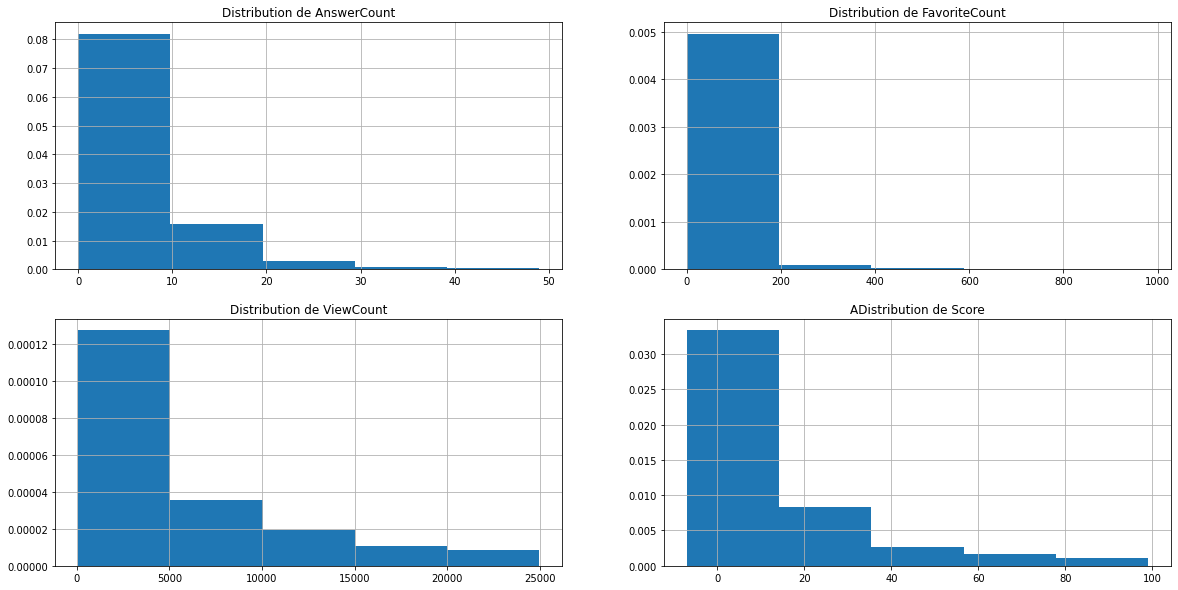

<Figure size 1440x720 with 0 Axes>

In [3]:
plt.rcParams['figure.figsize'] = (20, 10) #(L,l)

figure, axes = plt.subplots(2, 2)

ax1 = df1["AnswerCount"][df1.AnswerCount.abs() < 50].hist(ax=axes[0,0],density=True,bins=5)
ax1.set_title("Distribution de AnswerCount")
ax2 = df1[df1.FavoriteCount.abs() < 1000]["FavoriteCount"].hist(ax=axes[0,1],density=True,bins=5)
ax2.set_title("Distribution de FavoriteCount")
ax3 = df1[df1.ViewCount.abs() < 25000]["ViewCount"].hist(ax=axes[1,0],density=True,bins=5)
ax3.set_title("Distribution de ViewCount")
ax4 = df1[df1.Score.abs() < 100]["Score"].hist(ax=axes[1,1],density=True,bins=5)
ax4.set_title("ADistribution de Score")

plt.figure();

In [4]:
df1 = df1[(df1.AnswerCount.abs() > 10) &  (df1.FavoriteCount.abs() > 200) & \
          (df1.ViewCount.abs() > 5000) & \
             (df1.Score.abs() > 15) ] 
print(df1.shape)

(195, 23)


### PostsWithDeleted_df

In [6]:
PostsWithDeleted_df= pd.read_csv("PostsWithDeleted.csv")
print(PostsWithDeleted_df.shape)
df2 = PostsWithDeleted_df.dropna(subset=['Title', 'Tags'])
print(df2.shape)
df2.head()

(50000, 23)
(5425, 23)


,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
3,4,1,7.0,NaN,2008-07-31 21:42:52,NaN,735,59417.0,<p>I want to use a <code>Track-Bar</code> to c...,8.0,NaN,3072350.0,Rich B,2021-02-26 03:31:15,2021-02-26 03:31:15,How to convert a Decimal to a Double in C#?,<c#><floating-point><type-conversion><double><...,14.0,5.0,57.0,NaN,2012-10-31 16:42:47,CC BY-SA 4.0
5,6,1,31.0,NaN,2008-07-31 22:08:08,NaN,308,21790.0,<p>I have an absolutely positioned <code>div</...,9.0,NaN,9134576.0,user14723686,2021-01-29 18:46:45,2021-01-29 18:46:45,Why did the width collapse in the percentage w...,<html><css><internet-explorer-7>,7.0,1.0,12.0,NaN,NaN,CC BY-SA 4.0
8,9,1,1404.0,NaN,2008-07-31 23:40:59,NaN,2045,689094.0,<p>Given a <code>DateTime</code> representing ...,1.0,NaN,6537157.0,Rich B,2021-01-05 17:33:32,2021-08-14 13:35:38,How do I calculate someone's age based on a Da...,<c#><.net><datetime>,65.0,9.0,477.0,NaN,2011-08-16 19:40:43,CC BY-SA 4.0
10,11,1,1248.0,NaN,2008-07-31 23:55:37,NaN,1589,179565.0,<p>Given a specific <code>DateTime</code> valu...,1.0,NaN,6479704.0,user2370523,2017-06-04 15:51:19,2021-08-25 11:37:52,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,39.0,3.0,550.0,NaN,2009-09-04 13:15:59,CC BY-SA 3.0
12,13,1,NaN,NaN,2008-08-01 00:42:38,NaN,660,232796.0,<p>Is there a standard way for a web server to...,9.0,NaN,584192.0,Rich B,2020-12-03 03:37:56,2021-04-13 09:46:08,Determine a user's timezone,<html><browser><timezone><user-agent><timezone...,26.0,9.0,156.0,NaN,NaN,CC BY-SA 4.0


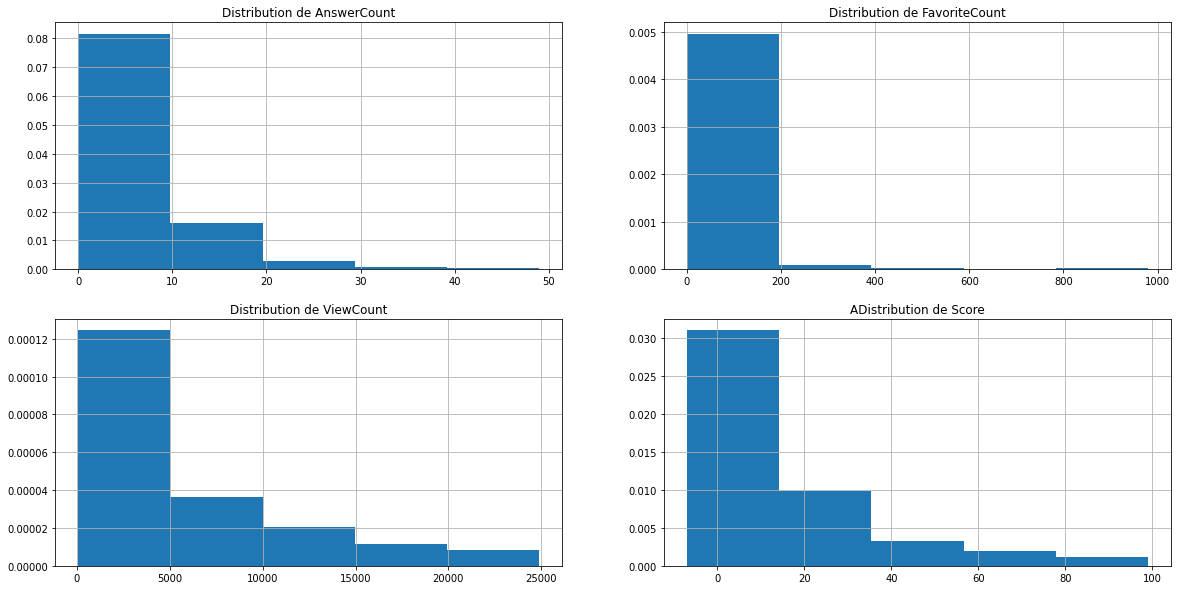

<Figure size 1440x720 with 0 Axes>

In [7]:
plt.rcParams['figure.figsize'] = (20, 10) #(L,l)

figure, axes = plt.subplots(2, 2)

ax1 = df2["AnswerCount"][df2.AnswerCount.abs() < 50].hist(ax=axes[0,0],density=True,bins=5)
ax1.set_title("Distribution de AnswerCount")
ax2 = df2[df2.FavoriteCount.abs() < 1000]["FavoriteCount"].hist(ax=axes[0,1],density=True,bins=5)
ax2.set_title("Distribution de FavoriteCount")
ax3 = df2[df2.ViewCount.abs() < 25000]["ViewCount"].hist(ax=axes[1,0],density=True,bins=5)
ax3.set_title("Distribution de ViewCount")
ax4 = df2[df2.Score.abs() < 100]["Score"].hist(ax=axes[1,1],density=True,bins=5)
ax4.set_title("ADistribution de Score")

plt.figure();

In [8]:
df2 = df2[(df2.AnswerCount.abs() > 10) & (df2.FavoriteCount.abs() >  200) & \
          
          (df2.ViewCount.abs() > 5000)   & \
           
             (df2.Score.abs() > 15)] 

In [9]:
df2.shape

(114, 23)

### SuggestedEdits_df

In [10]:
SuggestedEdits_df= pd.read_csv("SuggestedEdits.csv")
print(SuggestedEdits_df.shape)#max50000
df3 = SuggestedEdits_df.dropna(subset=['Title', 'Tags'])
print(df3.shape)
df3.head(3) 

(50000, 11)
(1706, 11)


,Id,PostId,CreationDate,ApprovalDate,RejectionDate,OwnerUserId,Comment,Text,Title,Tags,RevisionGUID
10,11,4733084,2011-01-19 08:18:58,2011-01-19 08:20:55,NaN,346285.0,NaN,i need to select one row where slot_left is th...,select row where the slot is the biggest,php,c1639b09-65a1-4042-bf47-83168b977a35
11,12,4733084,2011-01-19 08:26:59,2011-01-19 08:34:44,NaN,165969.0,added mysql+join tags,i need to select one row where slot_left is th...,select row where the slot is the biggest,php mysql join,ee3117b5-f8c3-4916-950d-a8bd6b9909b0
12,13,4733081,2011-01-19 08:28:15,2011-01-19 08:33:58,NaN,NaN,fix formatting,I am trying to set up a Facebook application w...,Retrieving friends info using Facebook API,facebook,aef63b27-07ff-4506-b156-32743bbf7ce6


### TagSynonyms_df

In [11]:
TagSynonyms_df= pd.read_csv("TagSynonyms.csv")
print(TagSynonyms_df.shape)#max 5284
df4 = TagSynonyms_df.dropna(subset=['SourceTagName', 'TargetTagName'])
print(df4.shape)
df4.head(2)

(5284, 10)
(5281, 10)


,Id,SourceTagName,TargetTagName,CreationDate,OwnerUserId,AutoRenameCount,LastAutoRename,Score,ApprovedByUserId,ApprovalDate
0,3,windows-forms,winforms,2010-07-14 06:34:55,23354,673,2021-08-21 15:52:20,0,23354.0,2010-07-14 06:34:55
1,5,c-sharp,c#,2010-07-14 22:30:24,17174,221,2021-08-09 12:32:55,0,17174.0,2010-07-14 22:30:24


<AxesSubplot:>

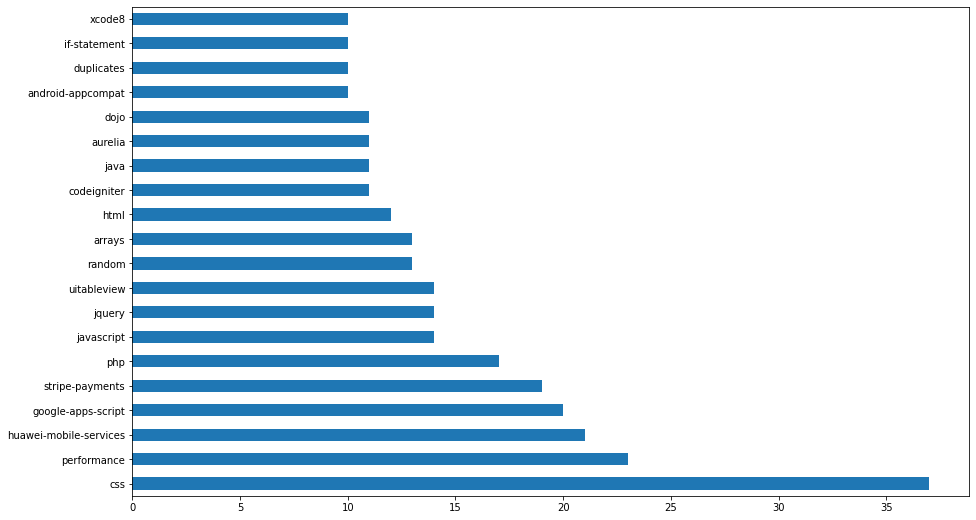

In [12]:
plt.rcParams['figure.figsize'] = (15,9)
df4["TargetTagName"].value_counts(normalize=False).iloc[0:20,].plot.barh()

### Tags_df

In [13]:
Tags_df= pd.read_csv("Tags.csv")
print(Tags_df.shape)#max 28801
df5 = Tags_df.dropna(subset=['TagName'])
print(df5.shape)
df5.head()

(28801, 7)
(28799, 7)


,Id,TagName,Count,ExcerptPostId,WikiPostId,IsModeratorOnly,IsRequired
0,1,.net,310638,3624959.0,3607476.0,NaN,NaN
1,2,html,1087765,3673183.0,3673182.0,NaN,NaN
2,3,javascript,2262606,3624960.0,3607052.0,NaN,NaN
3,4,css,729965,3644670.0,3644669.0,NaN,NaN
4,5,php,1412851,3624936.0,3607050.0,NaN,NaN


In [14]:
Tags_df["TagName"].nunique()

28799

### Concat des dataframes

In [15]:
df1.shape

(195, 23)

In [16]:
df2.shape

(114, 23)

In [17]:
df3.shape

(1706, 11)

In [18]:
df = pd.concat([df1[["Title", "Tags"]], df2[["Title", "Tags"]],df3[["Title", "Tags"]]])
print(df.shape)
df.head()

(2015, 2)


,Title,Tags
3,How do I calculate someone's age based on a Da...,<c#><.net><datetime>
4,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...
108,Versioning SQL Server database,<sql-server><database><svn><version-control>
175,How do you make sure email you send programmat...,<email><email-spam>
222,The definitive guide to form-based website aut...,<security><http><authentication><language-agno...


In [19]:
df.to_csv("1.csv",index=False)

## <font color="#337da4">Nettoyage des Tags</font>

In [21]:
import numpy as np
import matplotlib as plt
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re
import collections

In [22]:
df = pd.read_csv('./data/1.csv', index_col =False)

df["Tags"] = df["Tags"].astype(str)
liste = []

#tags to list of words
def liste_tags(string_to_change):
    
    for element in string_to_change:
        #drop the tags < >
        test = re.sub('><|<|>', ' ', element)
 
        #string to list of strings
        str_to_list = test.split()
        
        #list of lists of tags
        liste.append(str_to_list)

        
    l = pd.Series(liste)
    #s = s.astype(str)
        
    return l

df["Tags_List"] = liste_tags (df["Tags"])
df = df.drop(labels=['Tags'], axis=1)
df.head()


,Title,Tags_List
0,How do I calculate someone's age based on a Da...,"[c#, .net, datetime]"
1,Calculate relative time in C#,"[c#, datetime, time, datediff, relative-time-s..."
2,Versioning SQL Server database,"[sql-server, database, svn, version-control]"
3,How do you make sure email you send programmat...,"[email, email-spam]"
4,The definitive guide to form-based website aut...,"[security, http, authentication, language-agno..."


In [23]:
df.iloc[41]

Title        Hidden Features of Java
Tags_List                     [java]
Name: 41, dtype: object

In [24]:
for a in df["Tags_List"]:
    for n, i in enumerate(a):
        if i == "java":
            a[n] = "javascript"
    

In [25]:
df.iloc[41]

Title        Hidden Features of Java
Tags_List               [javascript]
Name: 41, dtype: object

### Selection de tous les Tags

In [26]:
#Replace the liste with java replaced by javascript
liste = df["Tags_List"].to_list()

#list of lists to list
tags_flat = [item for sublist in liste for item in sublist]
tags_flat

['c#',
 '.net',
 'datetime',
 'c#',
 'datetime',
 'time',
 'datediff',
 'relative-time-span',
 'sql-server',
 'database',
 'svn',
 'version-control',
 'email',
 'email-spam',
 'security',
 'http',
 'authentication',
 'language-agnostic',
 'article',
 'python',
 'itertools',
 'svn',
 'git',
 'python',
 'oop',
 'methods',
 'monkeypatching',
 'podcast',
 'compiler-construction',
 'language-agnostic',
 'resources',
 'user-interface',
 'model-view-controller',
 'design-patterns',
 'terminology',
 'mvp',
 'ruby',
 'shell',
 'interop',
 'html',
 'forms',
 'browser',
 'autocomplete',
 'html',
 'web-scraping',
 'html-parsing',
 'html-content-extraction',
 'python',
 'user-interface',
 'deployment',
 'tkinter',
 'release-management',
 'oop',
 'design-patterns',
 'inversion-of-control',
 'python',
 'object',
 'python',
 'language-agnostic',
 'algorithm',
 'optimization',
 'complexity-theory',
 'big-o',
 'performance',
 'database',
 'image',
 'theory',
 'storage',
 'blob',
 'c#',
 '.net',
 'profil

### Comptage des Tags

In [16]:
#counts tags
counter=collections.Counter(tags_flat)
dictionary=dict(counter)

df_tags_counts = pd.DataFrame(dictionary.items(), columns=['Tags', 'Counts'])
df_tags_counts = df_tags_counts.sort_values(by=['Counts'], ascending=False)
df_tags_counts.head()

,Tags,Counts
59,javascript,322
0,c#,205
126,iphone,187
96,php,148
167,objective-c,139


In [17]:
#The 100 most frequent tags - descending by Counts
tags_to_keep = df_tags_counts.iloc[0:100]
tags_to_keep

,Tags,Counts
59,javascript,322
0,c#,205
126,iphone,187
96,php,148
167,objective-c,139
449,android,128
158,jquery,87
62,c++,82
34,html,81
17,python,80


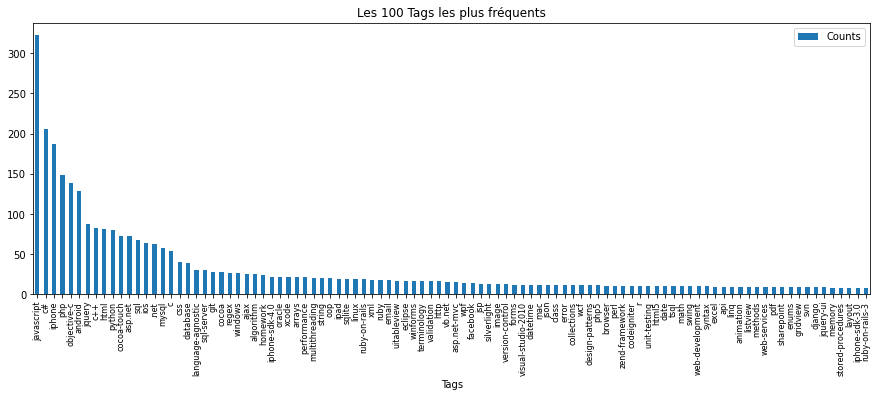

In [36]:


tags_to_keep.plot(x="Tags",y="Counts",kind="bar",figsize=(15, 5))
plt.xticks(rotation=90, fontsize=8)
plt.title("Les 100 Tags les plus fréquents")
plt.show()

### Selection des 100 Tags les plus fréquents

In [101]:
#series
tags_keeped = tags_to_keep["Tags"]
#tags_keeped.to_csv("100_tags.csv")
print(len(tags_keeped))
tags_keeped = tags_keeped.sort_values()
list_tags_keeped =tags_keeped.to_list()
list_tags_keeped

100


['.net',
 'ajax',
 'algorithm',
 'android',
 'animation',
 'api',
 'arrays',
 'asp.net',
 'asp.net-mvc',
 'browser',
 'c',
 'c#',
 'c++',
 'class',
 'cocoa',
 'cocoa-touch',
 'codeigniter',
 'collections',
 'css',
 'database',
 'date',
 'datetime',
 'design-patterns',
 'django',
 'eclipse',
 'email',
 'enums',
 'error',
 'excel',
 'facebook',
 'forms',
 'git',
 'gridview',
 'homework',
 'html',
 'html5',
 'http',
 'image',
 'ios',
 'ipad',
 'iphone',
 'iphone-sdk-3.0',
 'iphone-sdk-4.0',
 'javascript',
 'jquery',
 'jquery-ui',
 'json',
 'jsp',
 'language-agnostic',
 'layout',
 'linq',
 'linux',
 'listview',
 'mac',
 'math',
 'memory',
 'methods',
 'multithreading',
 'mysql',
 'objective-c',
 'oop',
 'oracle',
 'pdf',
 'performance',
 'perl',
 'php',
 'php5',
 'python',
 'r',
 'regex',
 'ruby',
 'ruby-on-rails',
 'ruby-on-rails-3',
 'sharepoint',
 'silverlight',
 'sql',
 'sql-server',
 'sqlite',
 'stored-procedures',
 'string',
 'svn',
 'swing',
 'syntax',
 'terminology',
 'tsql',
 'uit

### Application dans le df initial

In [34]:
df.head()

,Title,Tags_List
0,How do I calculate someone's age based on a Da...,"[c#, .net, datetime]"
1,Calculate relative time in C#,"[c#, datetime, time, datediff, relative-time-s..."
2,Versioning SQL Server database,"[sql-server, database, svn, version-control]"
3,How do you make sure email you send programmat...,"[email, email-spam]"
4,The definitive guide to form-based website aut...,"[security, http, authentication, language-agno..."


In [35]:
#Select only the 100 most frequent Tags
df['Tags_List'] = [[y for y in x if y in list_tags_keeped] for x in df['Tags_List']]

In [36]:
df.head()

,Title,Tags_List
0,How do I calculate someone's age based on a Da...,"[c#, .net, datetime]"
1,Calculate relative time in C#,"[c#, datetime]"
2,Versioning SQL Server database,"[sql-server, database, svn, version-control]"
3,How do you make sure email you send programmat...,[email]
4,The definitive guide to form-based website aut...,"[http, language-agnostic]"


In [37]:
#to_csv
df.to_csv("1.2.csv",index=False)

### Dummies des Tags

In [38]:
from sklearn.preprocessing import MultiLabelBinarizer

#Dummies for Tags

s = df['Tags_List']

mlb = MultiLabelBinarizer()

fd_y = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)

print(fd_y.shape)
fd_y.head()

(2015, 100)


,.net,ajax,algorithm,android,animation,api,arrays,asp.net,asp.net-mvc,browser,c,c#,c++,class,cocoa,cocoa-touch,codeigniter,collections,css,database,date,datetime,design-patterns,django,eclipse,email,enums,error,excel,facebook,forms,git,gridview,homework,html,html5,http,image,ios,ipad,iphone,iphone-sdk-3.0,iphone-sdk-4.0,javascript,jquery,jquery-ui,json,jsp,language-agnostic,layout,linq,linux,listview,mac,math,memory,methods,multithreading,mysql,objective-c,oop,oracle,pdf,performance,perl,php,php5,python,r,regex,ruby,ruby-on-rails,ruby-on-rails-3,sharepoint,silverlight,sql,sql-server,sqlite,stored-procedures,string,svn,swing,syntax,terminology,tsql,uitableview,unit-testing,validation,vb.net,version-control,visual-studio-2010,wcf,web-development,web-services,windows,winforms,wpf,xcode,xml,zend-framework
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
df_final = pd.concat([df["Title"],fd_y], axis = 1)
print(df_final.shape)
df_final.head()

(2015, 101)


,Title,.net,ajax,algorithm,android,animation,api,arrays,asp.net,asp.net-mvc,browser,c,c#,c++,class,cocoa,cocoa-touch,codeigniter,collections,css,database,date,datetime,design-patterns,django,eclipse,email,enums,error,excel,facebook,forms,git,gridview,homework,html,html5,http,image,ios,ipad,iphone,iphone-sdk-3.0,iphone-sdk-4.0,javascript,jquery,jquery-ui,json,jsp,language-agnostic,layout,linq,linux,listview,mac,math,memory,methods,multithreading,mysql,objective-c,oop,oracle,pdf,performance,perl,php,php5,python,r,regex,ruby,ruby-on-rails,ruby-on-rails-3,sharepoint,silverlight,sql,sql-server,sqlite,stored-procedures,string,svn,swing,syntax,terminology,tsql,uitableview,unit-testing,validation,vb.net,version-control,visual-studio-2010,wcf,web-development,web-services,windows,winforms,wpf,xcode,xml,zend-framework
0,How do I calculate someone's age based on a Da...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Calculate relative time in C#,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Versioning SQL Server database,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,How do you make sure email you send programmat...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The definitive guide to form-based website aut...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
df_final["Title"].isna().sum()

0

In [41]:
df_final.to_csv("2.csv",index=False)

**<font color="green">Il y a donc 100 tags représentant les 100 tags les plus fréquents.</font>**

### EDA Exploratory Data Analysis

In [42]:
df_y = df_final.drop(['Title'], axis=1)

counts = []

#list of tags
categories = list(df_y.columns.values)

for i in categories:
    #sum by columns
    counts.append((i, df_y[i].sum()))
    
df_stats = pd.DataFrame(counts, columns=['tags', 'nombre_titles'])
df_stats = df_stats.sort_values(by = "nombre_titles", ascending=False)
df_stats.iloc[0:10]

,tags,nombre_titles
43,javascript,321
11,c#,205
40,iphone,187
65,php,148
59,objective-c,139
3,android,128
44,jquery,87
12,c++,82
34,html,81
67,python,80


Text(0.5, 0, 'Tags')

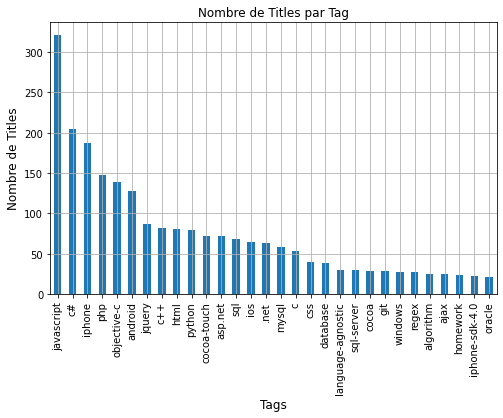

In [105]:
df_stats.iloc[0:30].plot(x='tags', y='nombre_titles', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Nombre de Titles par Tag")
plt.ylabel('Nombre de Titles', fontsize=12)
plt.xlabel('Tags', fontsize=12)

/home/catherinele/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Nombre de Tags')

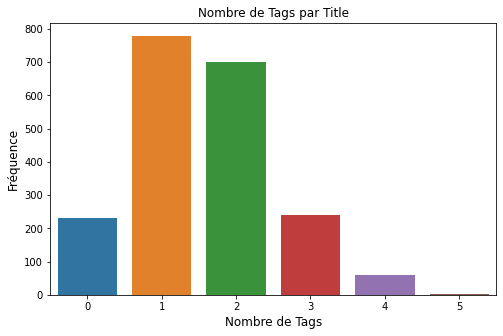

In [46]:
#sum by rows
rowsums = df_final.iloc[:,1:].sum(axis=1)
x=rowsums.value_counts()

plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Nombre de Tags par Title")
plt.ylabel('Fréquence', fontsize=12)
plt.xlabel('Nombre de Tags', fontsize=12)

Text(0.5, 1.0, 'Nombre de mots par Title')

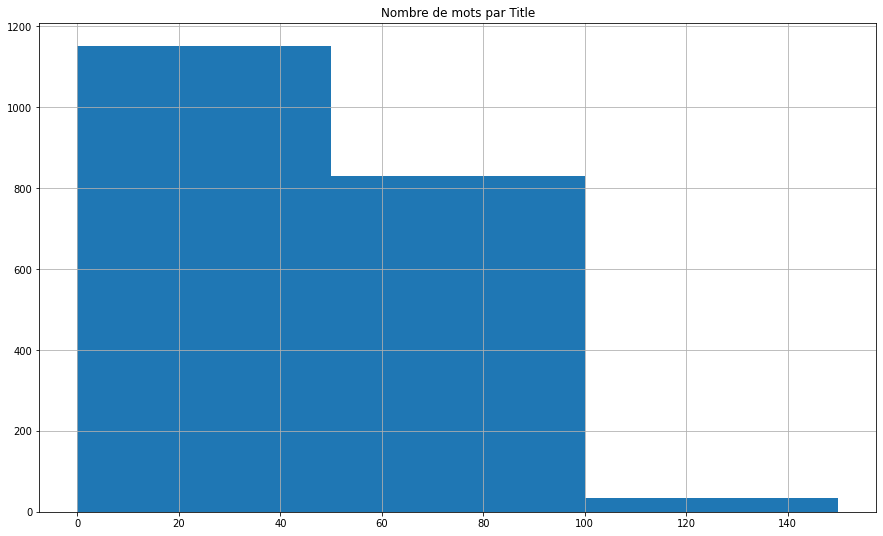

In [47]:
lens = df_final.Title.str.len()
lens.hist(bins = np.arange(0,200,50))
plt.title("Nombre de mots par Title")

La **normalisation** permet de ne pas prendre en compte la ponctuation, les majuscules, la conjugaison, etc. 

Les étapes suivantes permettront de supprimer 
- les caractères spéciaux via la tokenisation et le regex 
- la ponctuation via la tokénisation
- les majuscules via la tokenisation

## <font color="#337da4">Tokenisation des Titles</font>

In [1]:
import re
import nltk
import spacy
import gensim

In [6]:
df = pd.read_csv('./data/2.csv', index_col =False)
print(df.shape)
df.head()

(2015, 101)


,Title,.net,ajax,algorithm,android,animation,api,arrays,asp.net,asp.net-mvc,browser,c,c#,c++,class,cocoa,cocoa-touch,codeigniter,collections,css,database,date,datetime,design-patterns,django,eclipse,email,enums,error,excel,facebook,forms,git,gridview,homework,html,html5,http,image,ios,ipad,iphone,iphone-sdk-3.0,iphone-sdk-4.0,javascript,jquery,jquery-ui,json,jsp,language-agnostic,layout,linq,linux,listview,mac,math,memory,methods,multithreading,mysql,objective-c,oop,oracle,pdf,performance,perl,php,php5,python,r,regex,ruby,ruby-on-rails,ruby-on-rails-3,sharepoint,silverlight,sql,sql-server,sqlite,stored-procedures,string,svn,swing,syntax,terminology,tsql,uitableview,unit-testing,validation,vb.net,version-control,visual-studio-2010,wcf,web-development,web-services,windows,winforms,wpf,xcode,xml,zend-framework
0,How do I calculate someone's age based on a Da...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Calculate relative time in C#,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Versioning SQL Server database,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,How do you make sure email you send programmat...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The definitive guide to form-based website aut...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
df.isna().sum().sum()

0

**Les étapes:**
- Transformation en List of words 
- Suppression des caractères inutiles commes les balises  
- Formatage de c# et c++ pour être reconnu en tant que mot

In [7]:
# Series to list
data = df.Title.values.tolist()

#
data = [re.sub(r"\'|/|\|<|>|-|=|_|~|<", " ", sent) for sent in data] #ex: \'
data = [re.sub(r"#", 'diese', sent) for sent in data]
data = [re.sub(r"\+", 'plus', sent) for sent in data]
data[0:2015]

['How do I calculate someone s age based on a DateTime type birthday?',
 'Calculate relative time in Cdiese',
 'Versioning SQL Server database',
 'How do you make sure email you send programmatically is not automatically marked as spam?',
 'The definitive guide to form based website authentication',
 'How do I use itertools.groupby()?',
 'Why is Git better than Subversion?',
 'Adding a Method to an Existing Object Instance',
 'What good technology podcasts are out there?',
 'Learning to write a compiler',
 'What is the single most influential book every programmer should read?',
 'What are MVP and MVC and what is the difference?',
 'How to call shell commands from Ruby',
 'How do you disable browser autocomplete on web form field   input tags?',
 'Options for HTML scraping?',
 'Create a directly executable cross platform GUI app using Python',
 'What is Inversion of Control?',
 'Calling a function of a module by using its name (a string)',
 'Best ways to teach a beginner to program?',


**Tokenisation tout en supprimant la ponctuation, les majuscules et les mots à un seul caractère:**

In [8]:
#Tokenize = convert to list of words 

def sent_to_words(sentences):
    for sentence in sentences:
        
        # deacc= True removes punctuations
        #lowercase
        #remove one caracter only
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
        
        
data_words = list(sent_to_words(data))
print(data_words)

[['how', 'do', 'calculate', 'someone', 'age', 'based', 'on', 'datetime', 'type', 'birthday'], ['calculate', 'relative', 'time', 'in', 'cdiese'], ['versioning', 'sql', 'server', 'database'], ['how', 'do', 'you', 'make', 'sure', 'email', 'you', 'send', 'is', 'not', 'automatically', 'marked', 'as', 'spam'], ['the', 'definitive', 'guide', 'to', 'form', 'based', 'website', 'authentication'], ['how', 'do', 'use', 'itertools', 'groupby'], ['why', 'is', 'git', 'better', 'than', 'subversion'], ['adding', 'method', 'to', 'an', 'existing', 'object', 'instance'], ['what', 'good', 'technology', 'podcasts', 'are', 'out', 'there'], ['learning', 'to', 'write', 'compiler'], ['what', 'is', 'the', 'single', 'most', 'influential', 'book', 'every', 'programmer', 'should', 'read'], ['what', 'are', 'mvp', 'and', 'mvc', 'and', 'what', 'is', 'the', 'difference'], ['how', 'to', 'call', 'shell', 'commands', 'from', 'ruby'], ['how', 'do', 'you', 'disable', 'browser', 'autocomplete', 'on', 'web', 'form', 'field', 

## <font color="#337da4">Analyse des fréquences</font>

In [9]:
#list of lists to one list
data_words_flat = [item for sublist in data_words for item in sublist]
data_words_flat

['how',
 'do',
 'calculate',
 'someone',
 'age',
 'based',
 'on',
 'datetime',
 'type',
 'birthday',
 'calculate',
 'relative',
 'time',
 'in',
 'cdiese',
 'versioning',
 'sql',
 'server',
 'database',
 'how',
 'do',
 'you',
 'make',
 'sure',
 'email',
 'you',
 'send',
 'is',
 'not',
 'automatically',
 'marked',
 'as',
 'spam',
 'the',
 'definitive',
 'guide',
 'to',
 'form',
 'based',
 'website',
 'authentication',
 'how',
 'do',
 'use',
 'itertools',
 'groupby',
 'why',
 'is',
 'git',
 'better',
 'than',
 'subversion',
 'adding',
 'method',
 'to',
 'an',
 'existing',
 'object',
 'instance',
 'what',
 'good',
 'technology',
 'podcasts',
 'are',
 'out',
 'there',
 'learning',
 'to',
 'write',
 'compiler',
 'what',
 'is',
 'the',
 'single',
 'most',
 'influential',
 'book',
 'every',
 'programmer',
 'should',
 'read',
 'what',
 'are',
 'mvp',
 'and',
 'mvc',
 'and',
 'what',
 'is',
 'the',
 'difference',
 'how',
 'to',
 'call',
 'shell',
 'commands',
 'from',
 'ruby',
 'how',
 'do',
 'y

<AxesSubplot:title={'center':'Fréquence des mots'}>

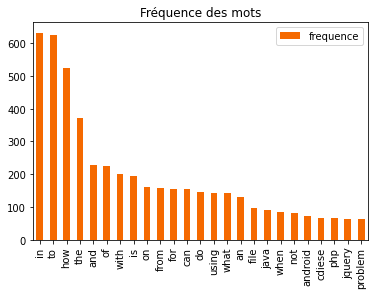

In [10]:
freq = fq = nltk.FreqDist(data_words_flat)
#Dataframe
df_freq = pd.DataFrame.from_dict(freq, orient='index', columns=["frequence"])

# Affichage des fréquences
df_freq = df_freq.sort_values( by="frequence",ascending=False).iloc[0:25]
df_freq.plot(kind='bar', color="#f56900", title='Fréquence des mots')

**On peut voir qu'il y a beaucoup de stopwords on on va les supprimer.**

## <font color="#337da4">Stopword puis Stemming</font>

"Racinisation(ou **stemming** en anglais): C'est un procédé plus simple que la lemmatisation et plus rapide à effectuer puisqu'on **tronque** les mots essentiellement contrairement à la lemmatisation qui nécessite d'utiliser un dictionnaire." 

cf. cours OC Analysez vos données textuelles

### PorterStemmer

In [60]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

nltk.corpus.stopwords.words('english')
corpus = []

for i in range(0,len(data_words)):
    title = data_words[i]  
    
    #ex : loved/loving = love
    ps = PorterStemmer() 
    
    #stemming and stopwords
    title = [ps.stem(word) for word in title if not word in set(stopwords.words('english'))]
    
    #list of words to list of sentences
    title = ' '.join(title)
    
    corpus.append(title)

corpus[0:10]


['calcul someon age base datetim type birthday',
 'calcul rel time cdies',
 'version sql server databas',
 'make sure email send automat mark spam',
 'definit guid form base websit authent',
 'use itertool groupbi',
 'git better subvers',
 'ad method exist object instanc',
 'good technolog podcast',
 'learn write compil']

**<font color="green">Le PorterStemmer() tronque le mot en perdant son sens. "rel" peut correspondre à plusieurs mots comme "relation", "rely" ect..</font>**

### SnowballStemmer

In [61]:
import nltk
#nltk.download()#to download the corpora press ' Download' button
from __future__ import print_function
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer

In [62]:
#Create a new instance of a language specific subclass.
stemmer = SnowballStemmer("english")
stemmer2 = SnowballStemmer("english", ignore_stopwords=True)
#test
print(stemmer.stem("running"))
print(stemmer2.stem("running"))

print(stemmer.stem("yourself")) 
print(stemmer2.stem("yourself")) #stopword qu'il ne tronque pas

run
run
yourself
yourself


In [78]:
#list of words to list of sentences
corpus =[]
for i in range(len(data_words)):
    title = ' '.join(data_words[i])
    corpus.append(title)  
corpus[0]

'calculate someone age based datetime type birthday'

In [79]:
singles = [stemmer2.stem(word) for word in corpus if not word in set(stopwords.words('english'))]
corpus[0:10]

['calculate someone age based datetime type birthday',
 'calculate relative time cdiese',
 'versioning sql server database',
 'make sure email send automatically marked spam',
 'definitive guide form based website authentication',
 'use itertools groupby',
 'git better subversion',
 'adding method existing object instance',
 'good technology podcasts',
 'learning write compiler']

**<font color="green">SnowballStemmer donne de bons résultats. Comparons avec la lemmatisation. </font>** 

## <font color="#337da4">Stopword puis Lemmatization</font>

¨Le processus de « **lemmatisation** » consiste à représenter les mots sous leur forme canonique. Par exemple pour un **verbe**, ce sera son **infinitif**. Pour un **nom**, son **masculin singulier**. L'idée étant encore une fois de ne conserver que le sens des mots utilisés dans le corpus.¨ 

cf cours OC  Cours Analysez vos données textuelles

**Stopwords**

In [13]:
nltk.corpus.stopwords.words('english')
print(len(nltk.corpus.stopwords.words('english')))

179


In [14]:
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [11]:
from nltk.corpus import stopwords
nltk.corpus.stopwords.words('english')

corpus = []
for i in range(0,len(df)):  
    
    #list of words
    review = data_words[i]
    review = [word for word in review if not word in set(stopwords.words('english'))]
    
    #list of words to list of sentences
    review = ' '.join(review) 
    corpus.append(review)

corpus

['calculate someone age based datetime type birthday',
 'calculate relative time cdiese',
 'versioning sql server database',
 'make sure email send automatically marked spam',
 'definitive guide form based website authentication',
 'use itertools groupby',
 'git better subversion',
 'adding method existing object instance',
 'good technology podcasts',
 'learning write compiler',
 'single influential book every programmer read',
 'mvp mvc difference',
 'call shell commands ruby',
 'disable browser autocomplete web form field input tags',
 'options html scraping',
 'create directly executable cross platform gui app using python',
 'inversion control',
 'calling function module using name string',
 'best ways teach beginner program',
 'big calculate approximate',
 'storing images db yea nay',
 'good net profilers',
 'recommended fonts programming',
 'length javascript object',
 'undo git reset hard head',
 'barriers understanding pointers done overcome',
 'difference string string cdiese

**Puis Lemmatization :**

In [70]:
liste=[]
for element in corpus:
    #list of sentence to list of words
    title = element.split()
    liste.append(title)
    
data_words = liste

data_words

[['calculate', 'someone', 'age', 'based', 'datetime', 'type', 'birthday'],
 ['calculate', 'relative', 'time', 'cdiese'],
 ['versioning', 'sql', 'server', 'database'],
 ['make', 'sure', 'email', 'send', 'automatically', 'marked', 'spam'],
 ['definitive', 'guide', 'form', 'based', 'website', 'authentication'],
 ['use', 'itertools', 'groupby'],
 ['git', 'better', 'subversion'],
 ['adding', 'method', 'existing', 'object', 'instance'],
 ['good', 'technology', 'podcasts'],
 ['learning', 'write', 'compiler'],
 ['single', 'influential', 'book', 'every', 'programmer', 'read'],
 ['mvp', 'mvc', 'difference'],
 ['call', 'shell', 'commands', 'ruby'],
 ['disable',
  'browser',
  'autocomplete',
  'web',
  'form',
  'field',
  'input',
  'tags'],
 ['options', 'html', 'scraping'],
 ['create',
  'directly',
  'executable',
  'cross',
  'platform',
  'gui',
  'app',
  'using',
  'python'],
 ['inversion', 'control'],
 ['calling', 'function', 'module', 'using', 'name', 'string'],
 ['best', 'ways', 'teach'

In [71]:
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)

# Run in terminal: python -m spacy download en
# Run in terminal: python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm' , disable=['parser' , 'ner' ])

In [72]:
'''
texts: list of lists of words

'''
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    
    texts_out = []
    
    for sent in texts:
        
        #words to sentence
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    
    return texts_out

In [73]:
#not lemmatized yet
doc = nlp(" ".join(data_words[67])) 
doc

differences generics cdiese java templates cplusplus

In [75]:
# Do lemmatization keeping only Noun, Adj, Verb, Adverb

data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) 

for i in range(len(data_lemmatized)):
    print(i,data_lemmatized[i])


0 calculate age base type birthday
1 calculate time cdiese
2 versione server database
3 make email send mark spam
4 guide form base website authentication
5 use itertool groupby
6 subversion
7 add method exist object instance
8 technology podcast
9 learn compiler
10 book programmer read
11 mvp difference
12 call shell command
13 browser web form field input tag
14 scrape
15 create cross platform app use python
16 inversion control
17 call function module use name string
18 way teach beginner program
19 calculate
20 store image nay
21 profiler
22 recommend font program
23 length javascript object
24 reset head
25 barrier understand pointer do overcome
26 difference string string cdiese
27 practice secure rest api web service
28 database table column name convention
29 flag enum attribute mean
30 image base approach
31 entity framework sql
32 hide feature
33 grep file show surround line
34 set editor work window
35 query
36 unit test multithreade code
37 difference struct class net
38 my

1979 remove space line server response
1980 array manipulation
1981 asp mvc change password issue firefox
1982 share datum xcode
1983 proxy system net
1984 reason follow
1985 use php output superscripte text
1986 javascript css file
1987 access machine level configuration mono linux
1988 loop problem
1989 place selectbox inputbox line
1990 turn bluetooth window phone app
1991 scroll property text field
1992 search bluetooth device window phone use silverlight
1993 mysql throw error change encoding
1994 check contact app
1995 use formvalidation codeigniter
1996 grab html tag
1997 install fail assembler architecture instal
1998 ruby rail tutorial mate gemfile problem
1999 put uilabel react size iphone
2000 option entry json
2001 problem retrieve file upload control
2002 problem fill list gridview dataset
2003 problem set file name imageviewer
2004 redirect hold script
2005 build release distribution xcode
2006 record video iphone use avfoundation
2007 query get key database
2008 implemen

'difference generic cdiese template cplusplus'

In [76]:
data_lemmatized[67] 

'difference generic cdiese template cplusplus'

In [77]:
# Select ['ADJ'] 
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB','ADJ']) 
data_lemmatized[67]  #OK

'difference generic cdiese java template cplusplus'

In [80]:
data_lemmatized[0:10]

['calculate age base datetime type birthday',
 'calculate relative time cdiese',
 'versione server database',
 'make sure email send mark spam',
 'definitive guide form base website authentication',
 'use itertool groupby',
 'well subversion',
 'add method exist object instance',
 'good technology podcast',
 'learn compiler']

**Comparons avec le SnowballStemmer:**

In [81]:
singles = [stemmer2.stem(word) for word in corpus if not word in set(stopwords.words('english'))]
corpus[0:10]

['calculate someone age based datetime type birthday',
 'calculate relative time cdiese',
 'versioning sql server database',
 'make sure email send automatically marked spam',
 'definitive guide form based website authentication',
 'use itertools groupby',
 'git better subversion',
 'adding method existing object instance',
 'good technology podcasts',
 'learning write compiler']

**<font color="green">Nous retenons la lemmatization car elle supprime des mots non nécessaires tels que "someone"ou "automatically".</font>**


In [96]:
#list to series
series = pd.Series(data_lemmatized, name = "Title")
df_final = series.to_frame()
print(df_final.shape)
df_final.head(50)

(2015, 1)


,Title
0,calculate age base datetime type birthday
1,calculate relative time cdiese
2,versione server database
3,make sure email send mark spam
4,definitive guide form base website authentication
5,use itertool groupby
6,well subversion
7,add method exist object instance
8,good technology podcast
9,learn compiler


In [97]:
df_final.isna().sum()

Title    0
dtype: int64

In [98]:
df_final= pd.concat([df_final,df_y], axis = 1)
df_final = df_final.dropna(axis=0)
print(df_final.shape)
df_final.head()

(2015, 101)


,Title,.net,ajax,algorithm,android,animation,api,arrays,asp.net,asp.net-mvc,browser,c,c#,c++,class,cocoa,cocoa-touch,codeigniter,collections,css,database,date,datetime,design-patterns,django,eclipse,email,enums,error,excel,facebook,forms,git,gridview,homework,html,html5,http,image,ios,ipad,iphone,iphone-sdk-3.0,iphone-sdk-4.0,javascript,jquery,jquery-ui,json,jsp,language-agnostic,layout,linq,linux,listview,mac,math,memory,methods,multithreading,mysql,objective-c,oop,oracle,pdf,performance,perl,php,php5,python,r,regex,ruby,ruby-on-rails,ruby-on-rails-3,sharepoint,silverlight,sql,sql-server,sqlite,stored-procedures,string,svn,swing,syntax,terminology,tsql,uitableview,unit-testing,validation,vb.net,version-control,visual-studio-2010,wcf,web-development,web-services,windows,winforms,wpf,xcode,xml,zend-framework
0,calculate age base datetime type birthday,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,calculate relative time cdiese,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,versione server database,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,make sure email send mark spam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,definitive guide form base website authentication,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [99]:
df_final["Title"].isna().sum()

0

In [100]:
df_final.to_csv("3.csv",index=False)

## <font color="#337da4">Analyse des fréquences</font>

In [39]:
df = pd.read_csv('./data/3.csv', index_col =False)
print(df.shape)
df.head()

(2015, 101)


,Title,.net,ajax,algorithm,android,animation,api,arrays,asp.net,asp.net-mvc,browser,c,c#,c++,class,cocoa,cocoa-touch,codeigniter,collections,css,database,date,datetime,design-patterns,django,eclipse,email,enums,error,excel,facebook,forms,git,gridview,homework,html,html5,http,image,ios,ipad,iphone,iphone-sdk-3.0,iphone-sdk-4.0,javascript,jquery,jquery-ui,json,jsp,language-agnostic,layout,linq,linux,listview,mac,math,memory,methods,multithreading,mysql,objective-c,oop,oracle,pdf,performance,perl,php,php5,python,r,regex,ruby,ruby-on-rails,ruby-on-rails-3,sharepoint,silverlight,sql,sql-server,sqlite,stored-procedures,string,svn,swing,syntax,terminology,tsql,uitableview,unit-testing,validation,vb.net,version-control,visual-studio-2010,wcf,web-development,web-services,windows,winforms,wpf,xcode,xml,zend-framework
0,calculate age base datetime type birthday,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,calculate relative time cdiese,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,versione server database,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,make sure email send mark spam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,definitive guide form base website authentication,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
list(df.columns)

['Title',
 '.net',
 'ajax',
 'algorithm',
 'android',
 'animation',
 'api',
 'arrays',
 'asp.net',
 'asp.net-mvc',
 'browser',
 'c',
 'c#',
 'c++',
 'class',
 'cocoa',
 'cocoa-touch',
 'codeigniter',
 'collections',
 'css',
 'database',
 'date',
 'datetime',
 'design-patterns',
 'django',
 'eclipse',
 'email',
 'enums',
 'error',
 'excel',
 'facebook',
 'forms',
 'git',
 'gridview',
 'homework',
 'html',
 'html5',
 'http',
 'image',
 'ios',
 'ipad',
 'iphone',
 'iphone-sdk-3.0',
 'iphone-sdk-4.0',
 'javascript',
 'jquery',
 'jquery-ui',
 'json',
 'jsp',
 'language-agnostic',
 'layout',
 'linq',
 'linux',
 'listview',
 'mac',
 'math',
 'memory',
 'methods',
 'multithreading',
 'mysql',
 'objective-c',
 'oop',
 'oracle',
 'pdf',
 'performance',
 'perl',
 'php',
 'php5',
 'python',
 'r',
 'regex',
 'ruby',
 'ruby-on-rails',
 'ruby-on-rails-3',
 'sharepoint',
 'silverlight',
 'sql',
 'sql-server',
 'sqlite',
 'stored-procedures',
 'string',
 'svn',
 'swing',
 'syntax',
 'terminology',
 'ts

### Fréquence des mots 

In [41]:
df["Title"] = df["Title"].astype(str)
series = df["Title"]

allwords = []
#split()
for element in  series:
    element = element.split()
    allwords +=  element
print(allwords)

['calculate', 'age', 'base', 'datetime', 'type', 'birthday', 'calculate', 'relative', 'time', 'cdiese', 'versione', 'server', 'database', 'make', 'sure', 'email', 'send', 'mark', 'spam', 'definitive', 'guide', 'form', 'base', 'website', 'authentication', 'use', 'itertool', 'groupby', 'well', 'subversion', 'add', 'method', 'exist', 'object', 'instance', 'good', 'technology', 'podcast', 'learn', 'compiler', 'single', 'influential', 'book', 'programmer', 'read', 'mvp', 'mvc', 'difference', 'call', 'shell', 'command', 'disable', 'browser', 'web', 'form', 'field', 'input', 'tag', 'scrape', 'create', 'executable', 'cross', 'platform', 'app', 'use', 'python', 'inversion', 'control', 'call', 'function', 'module', 'use', 'name', 'string', 'good', 'way', 'teach', 'beginner', 'program', 'big', 'calculate', 'approximate', 'store', 'image', 'yea', 'nay', 'good', 'net', 'profiler', 'recommend', 'font', 'program', 'length', 'javascript', 'object', 'reset', 'hard', 'head', 'barrier', 'understand', 'po

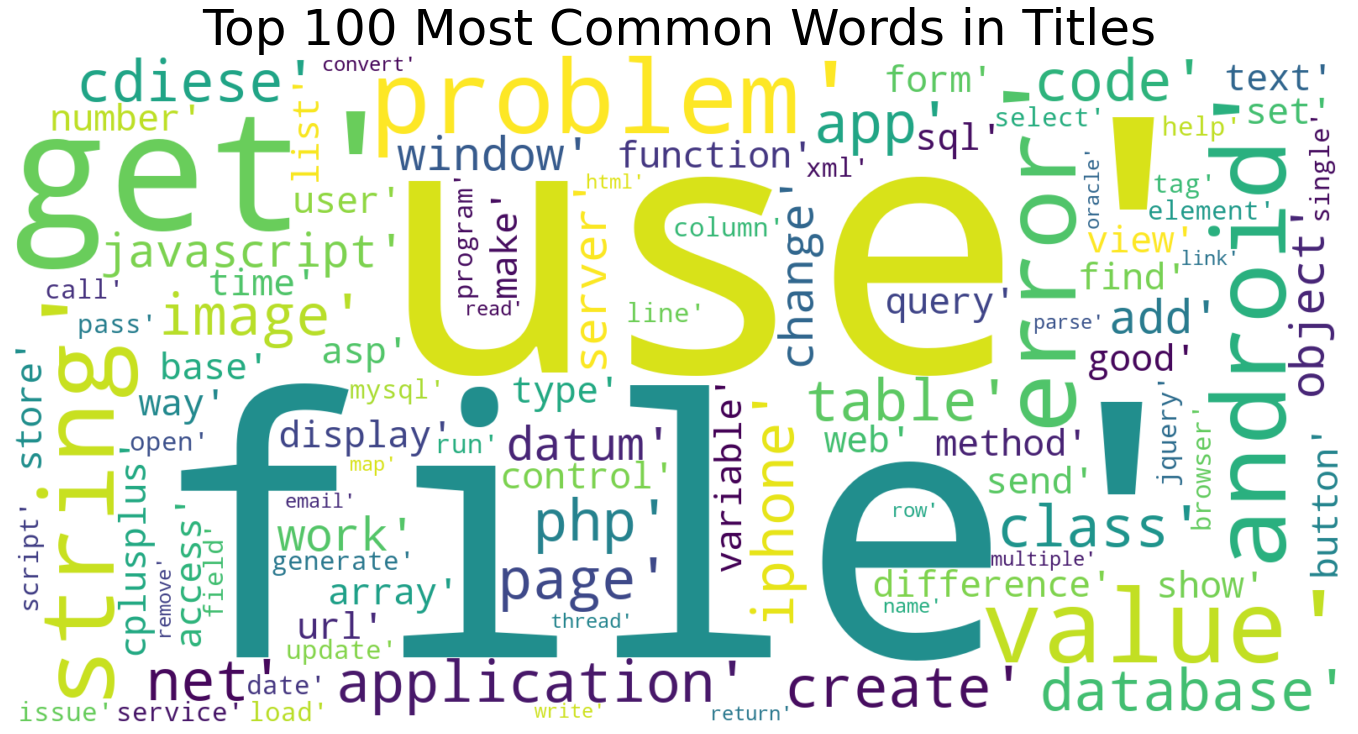

In [42]:
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

mostcommon = FreqDist(allwords).most_common(100)

wordcloud = WordCloud(width=1600, 
                      height=800, 
                      background_color='white').generate(str(mostcommon))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in Titles', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

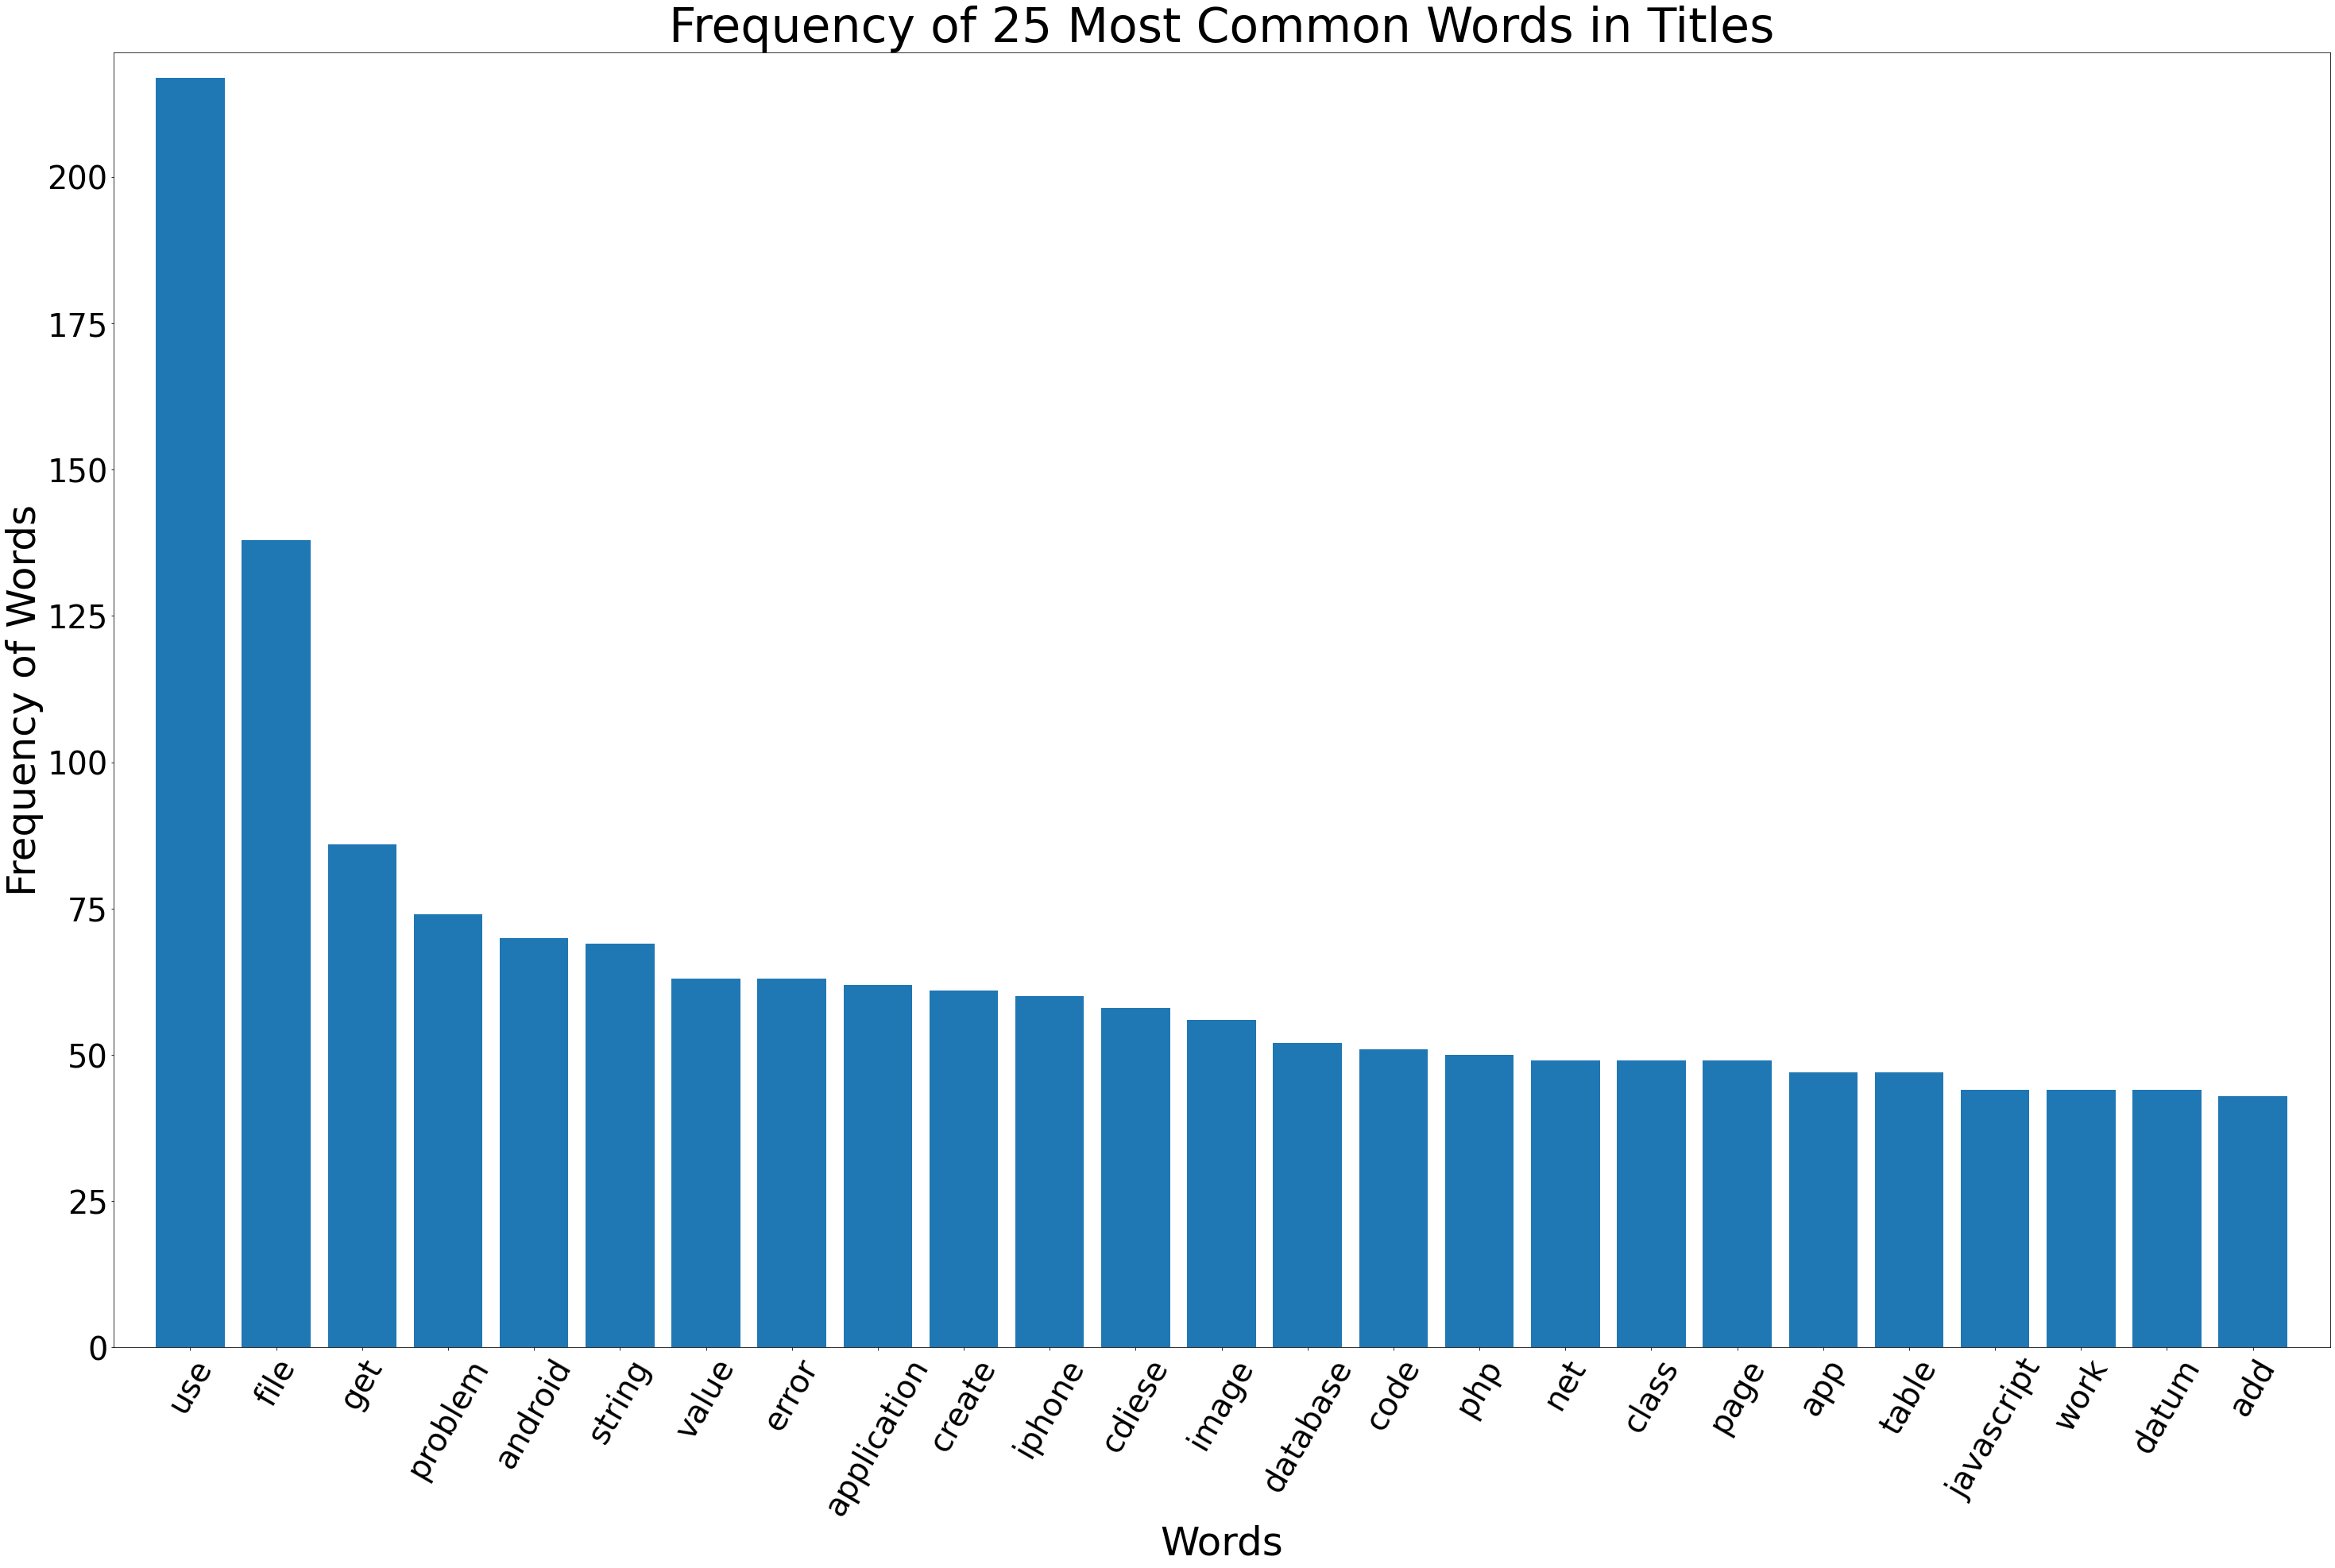

In [43]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words in Titles', fontsize=60)
plt.show()

### Fréquence des Tags

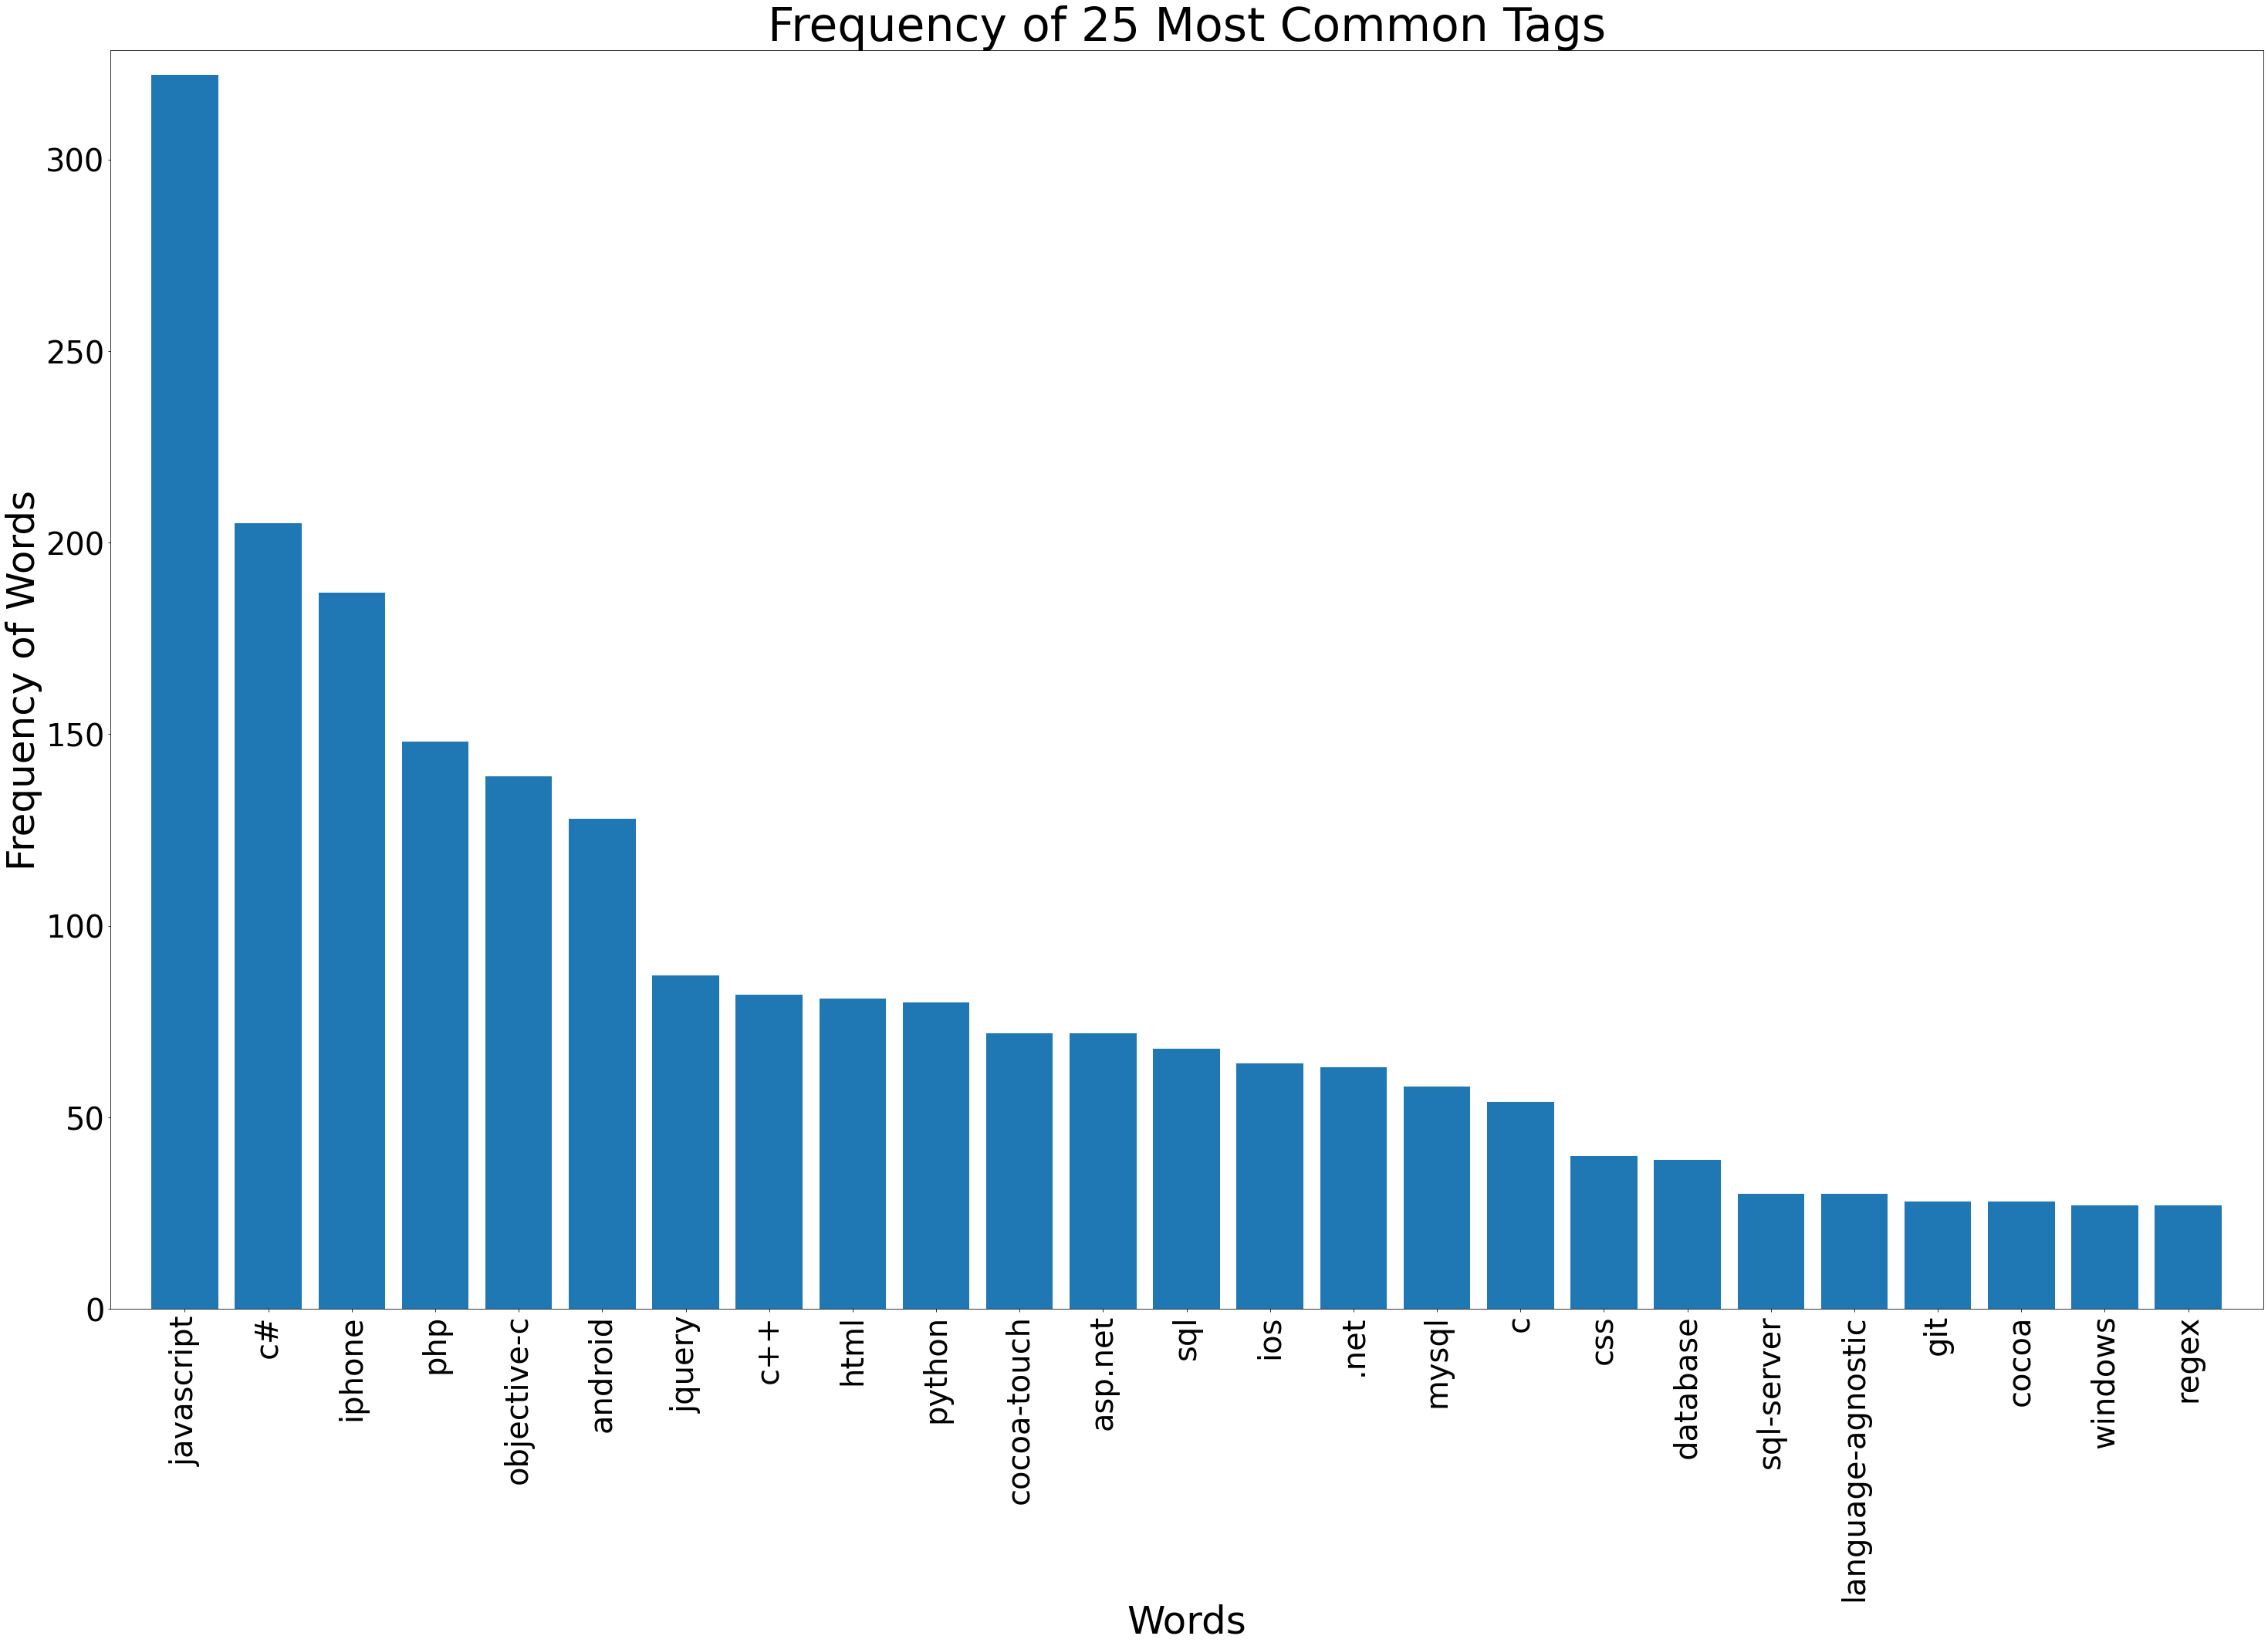

In [44]:
from nltk.probability import FreqDist

mostcommon_small = FreqDist(tags_flat).most_common(25)
x, y = zip(*mostcommon_small)

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=90, fontsize=40)
plt.title('Frequency of 25 Most Common Tags', fontsize=60)
plt.show()

### Fréquence des mots par Tags

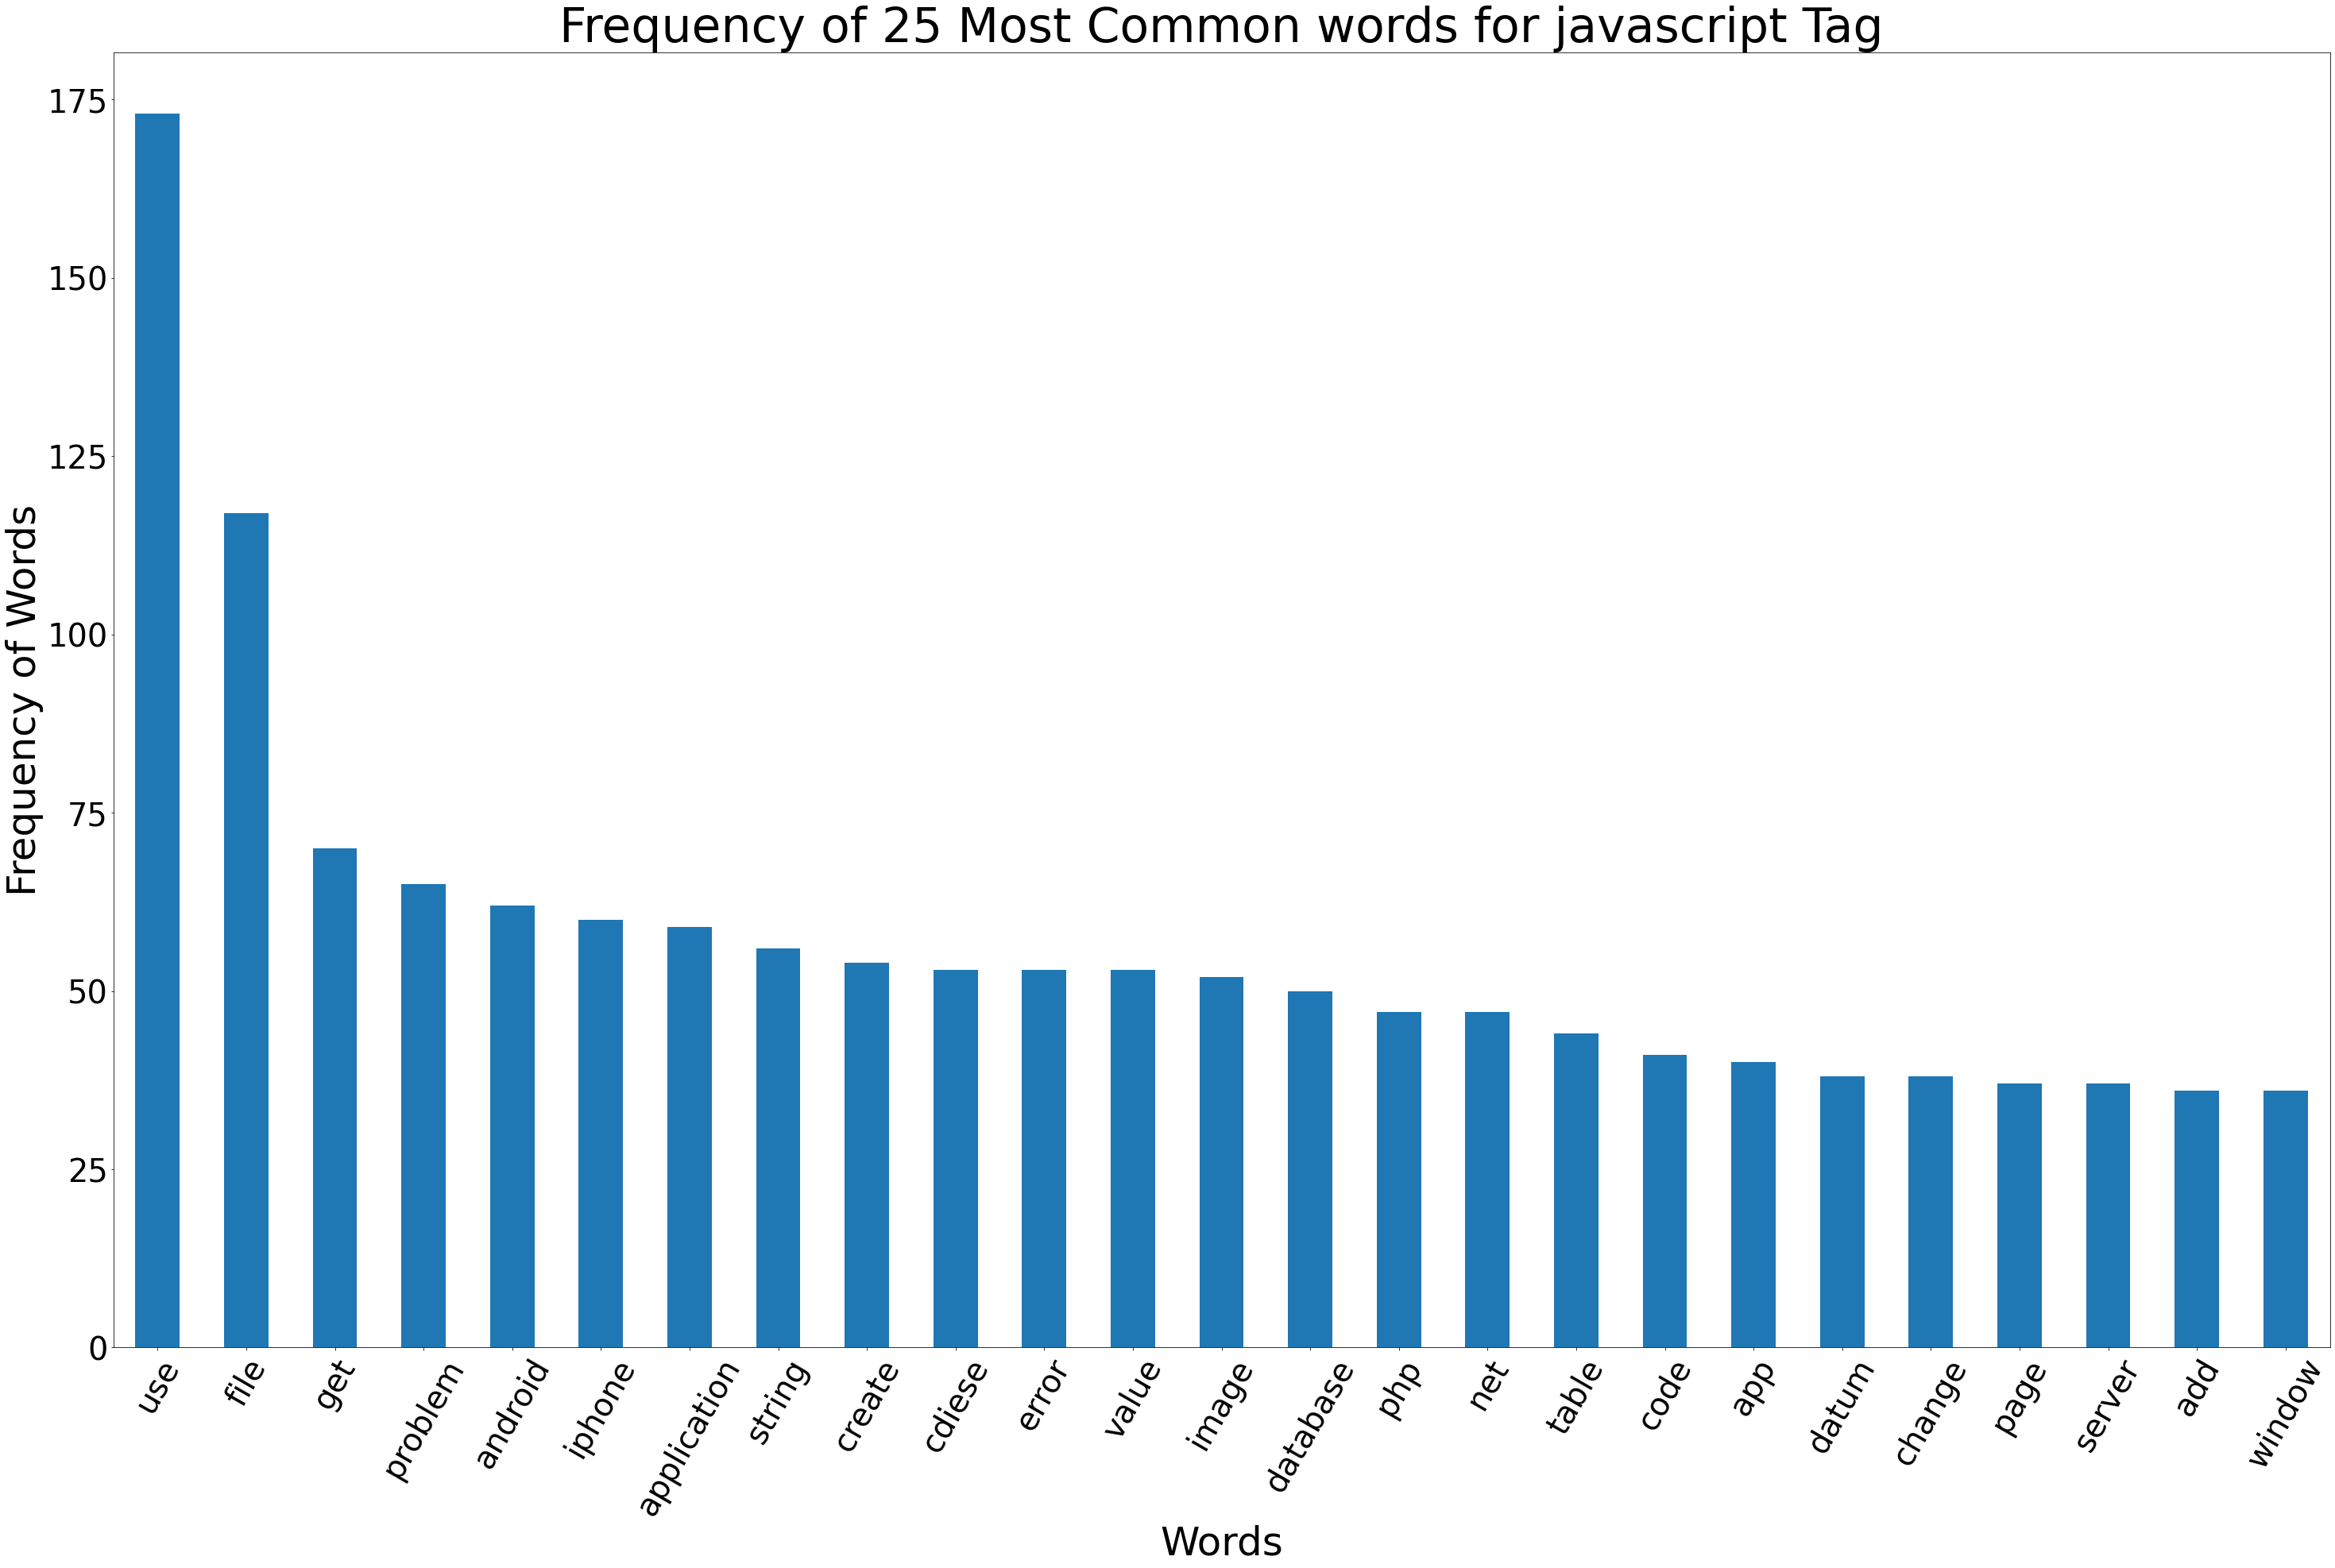

In [45]:
plt.figure(figsize=(50,30))

group_by = df.groupby('javascript')['Title'].apply(lambda x: collections.Counter(' '.join(x).split()))
group_by[0].sort_values(ascending=False).iloc[0:25].plot(kind='bar')      

plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title("Frequency of 25 Most Common words for javascript Tag", fontsize=60)
plt.show()

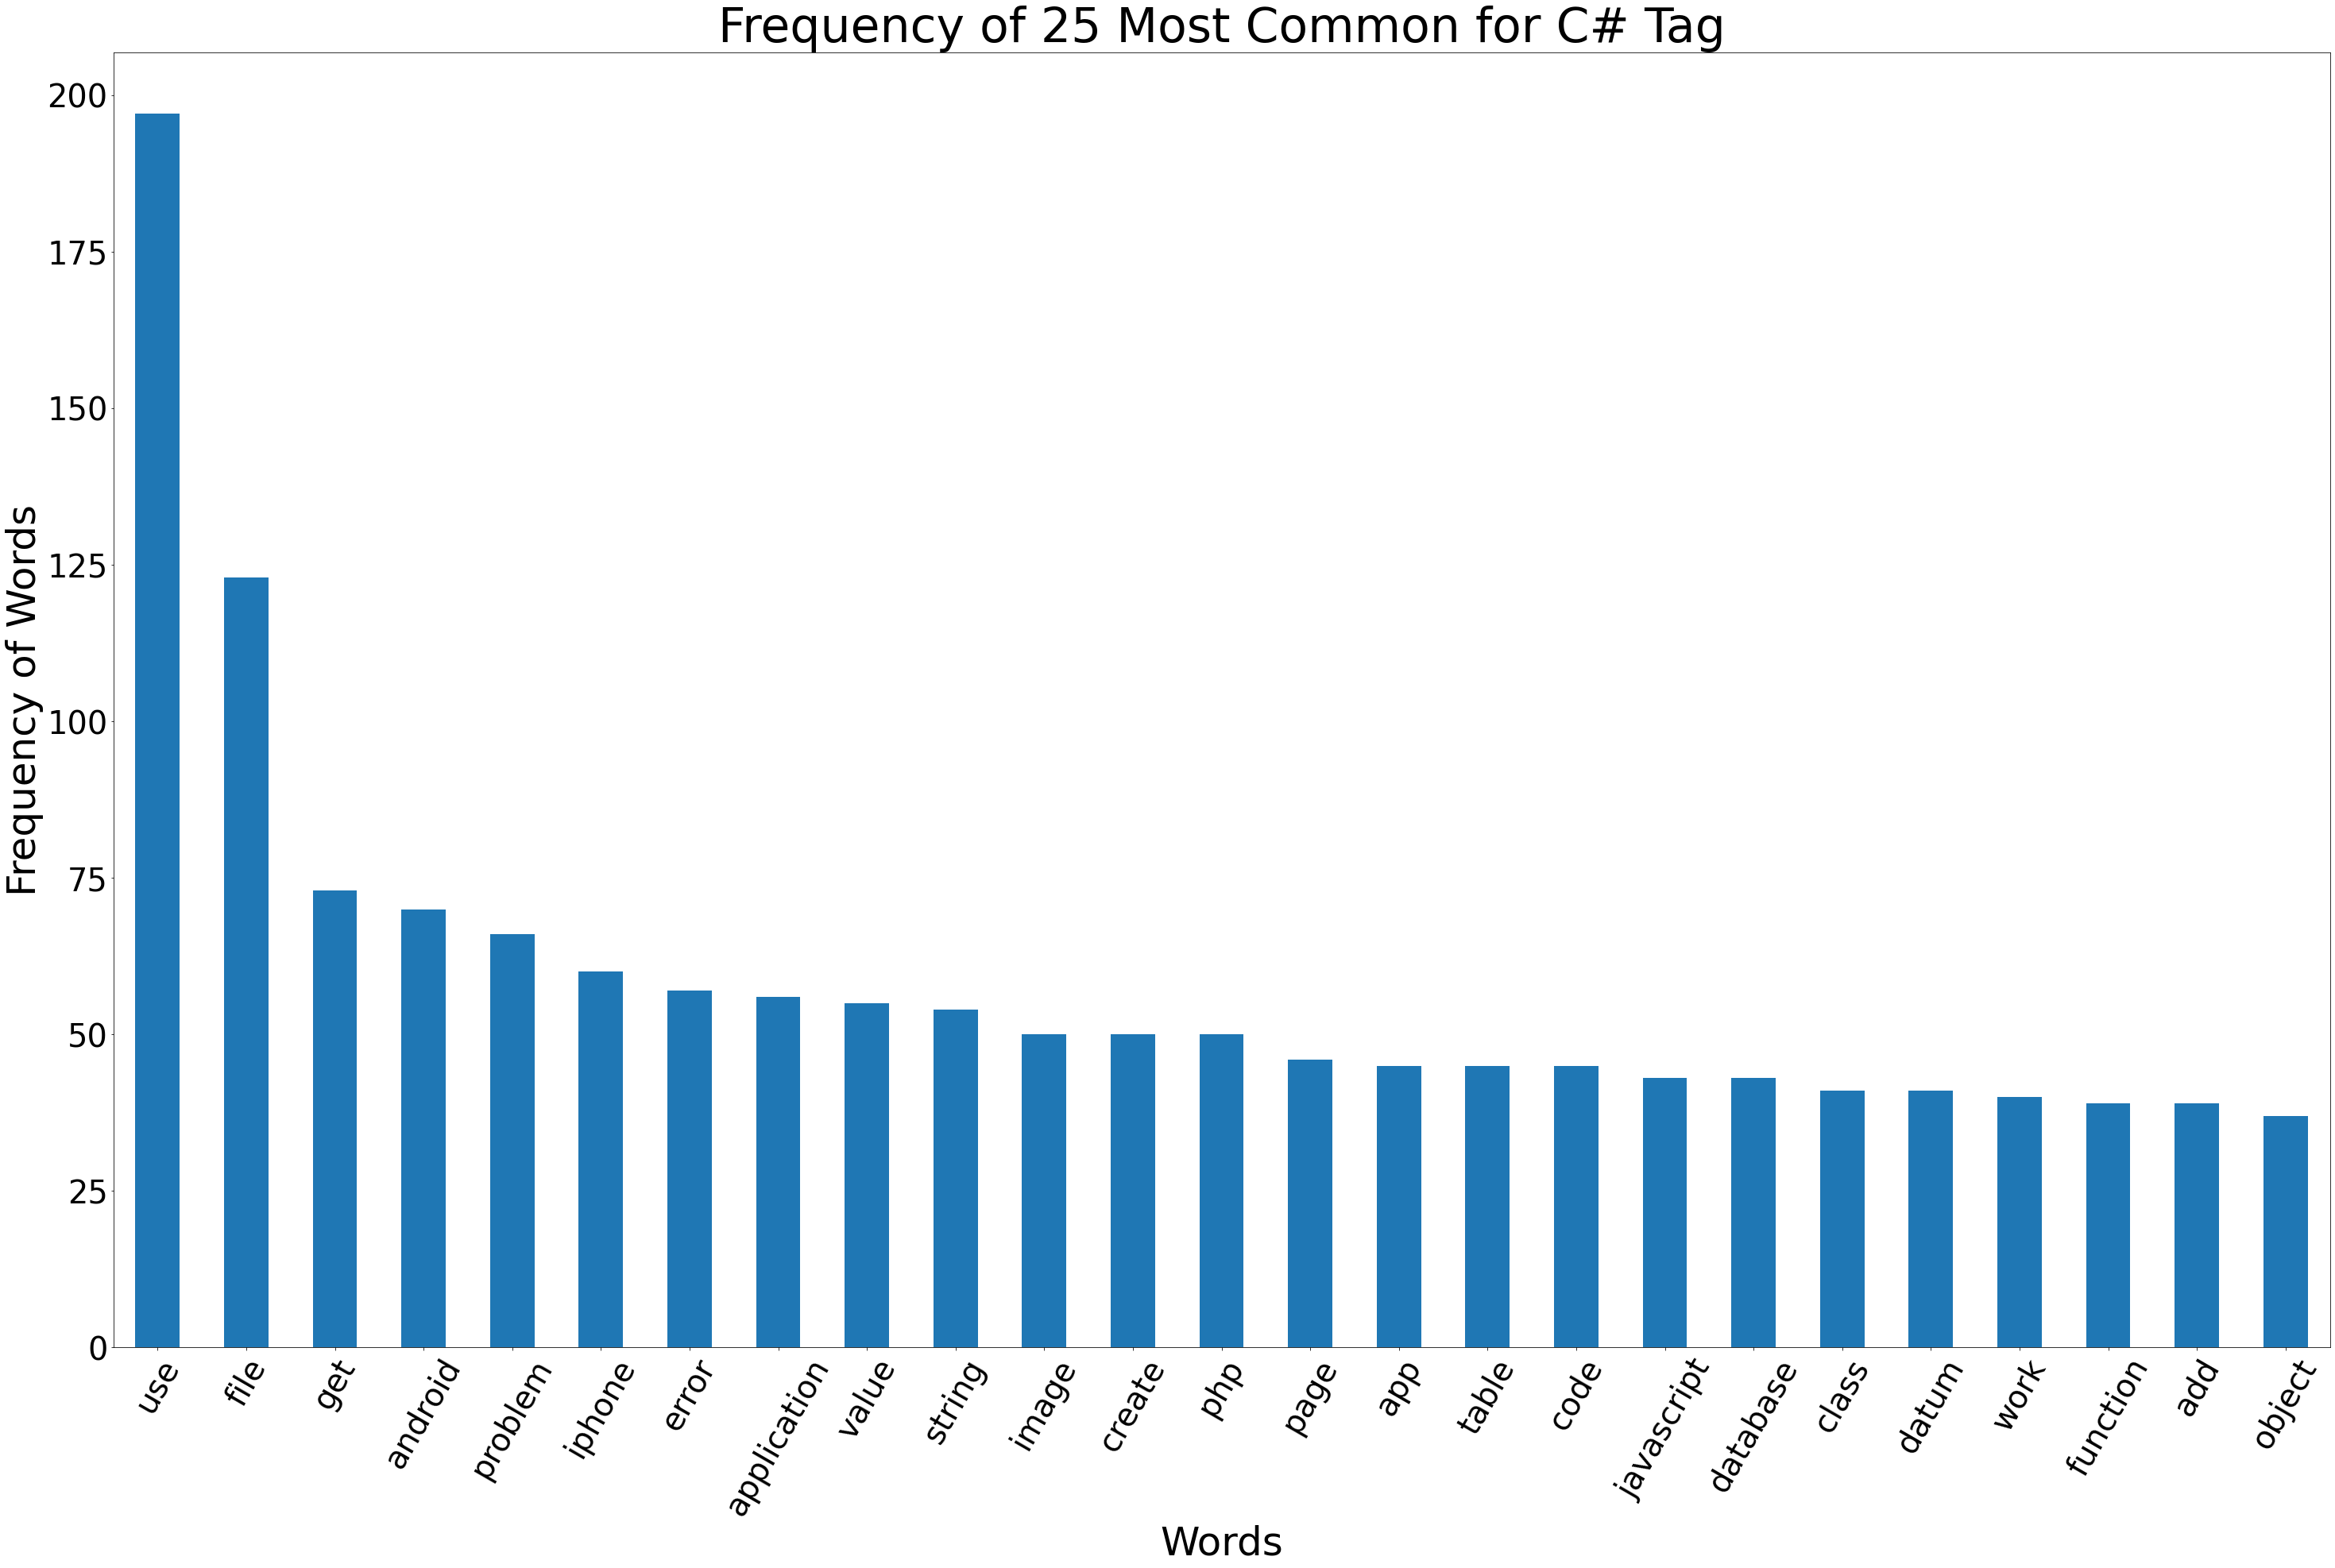

In [94]:
import collections
plt.figure(figsize=(50,30))

group_by = df.groupby('c#')['Title'].apply(lambda x: collections.Counter(' '.join(x).split()))
group_by[0].sort_values(ascending=False).iloc[0:25].plot(kind='bar')     

plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common for C# Tag', fontsize=60)
plt.show()

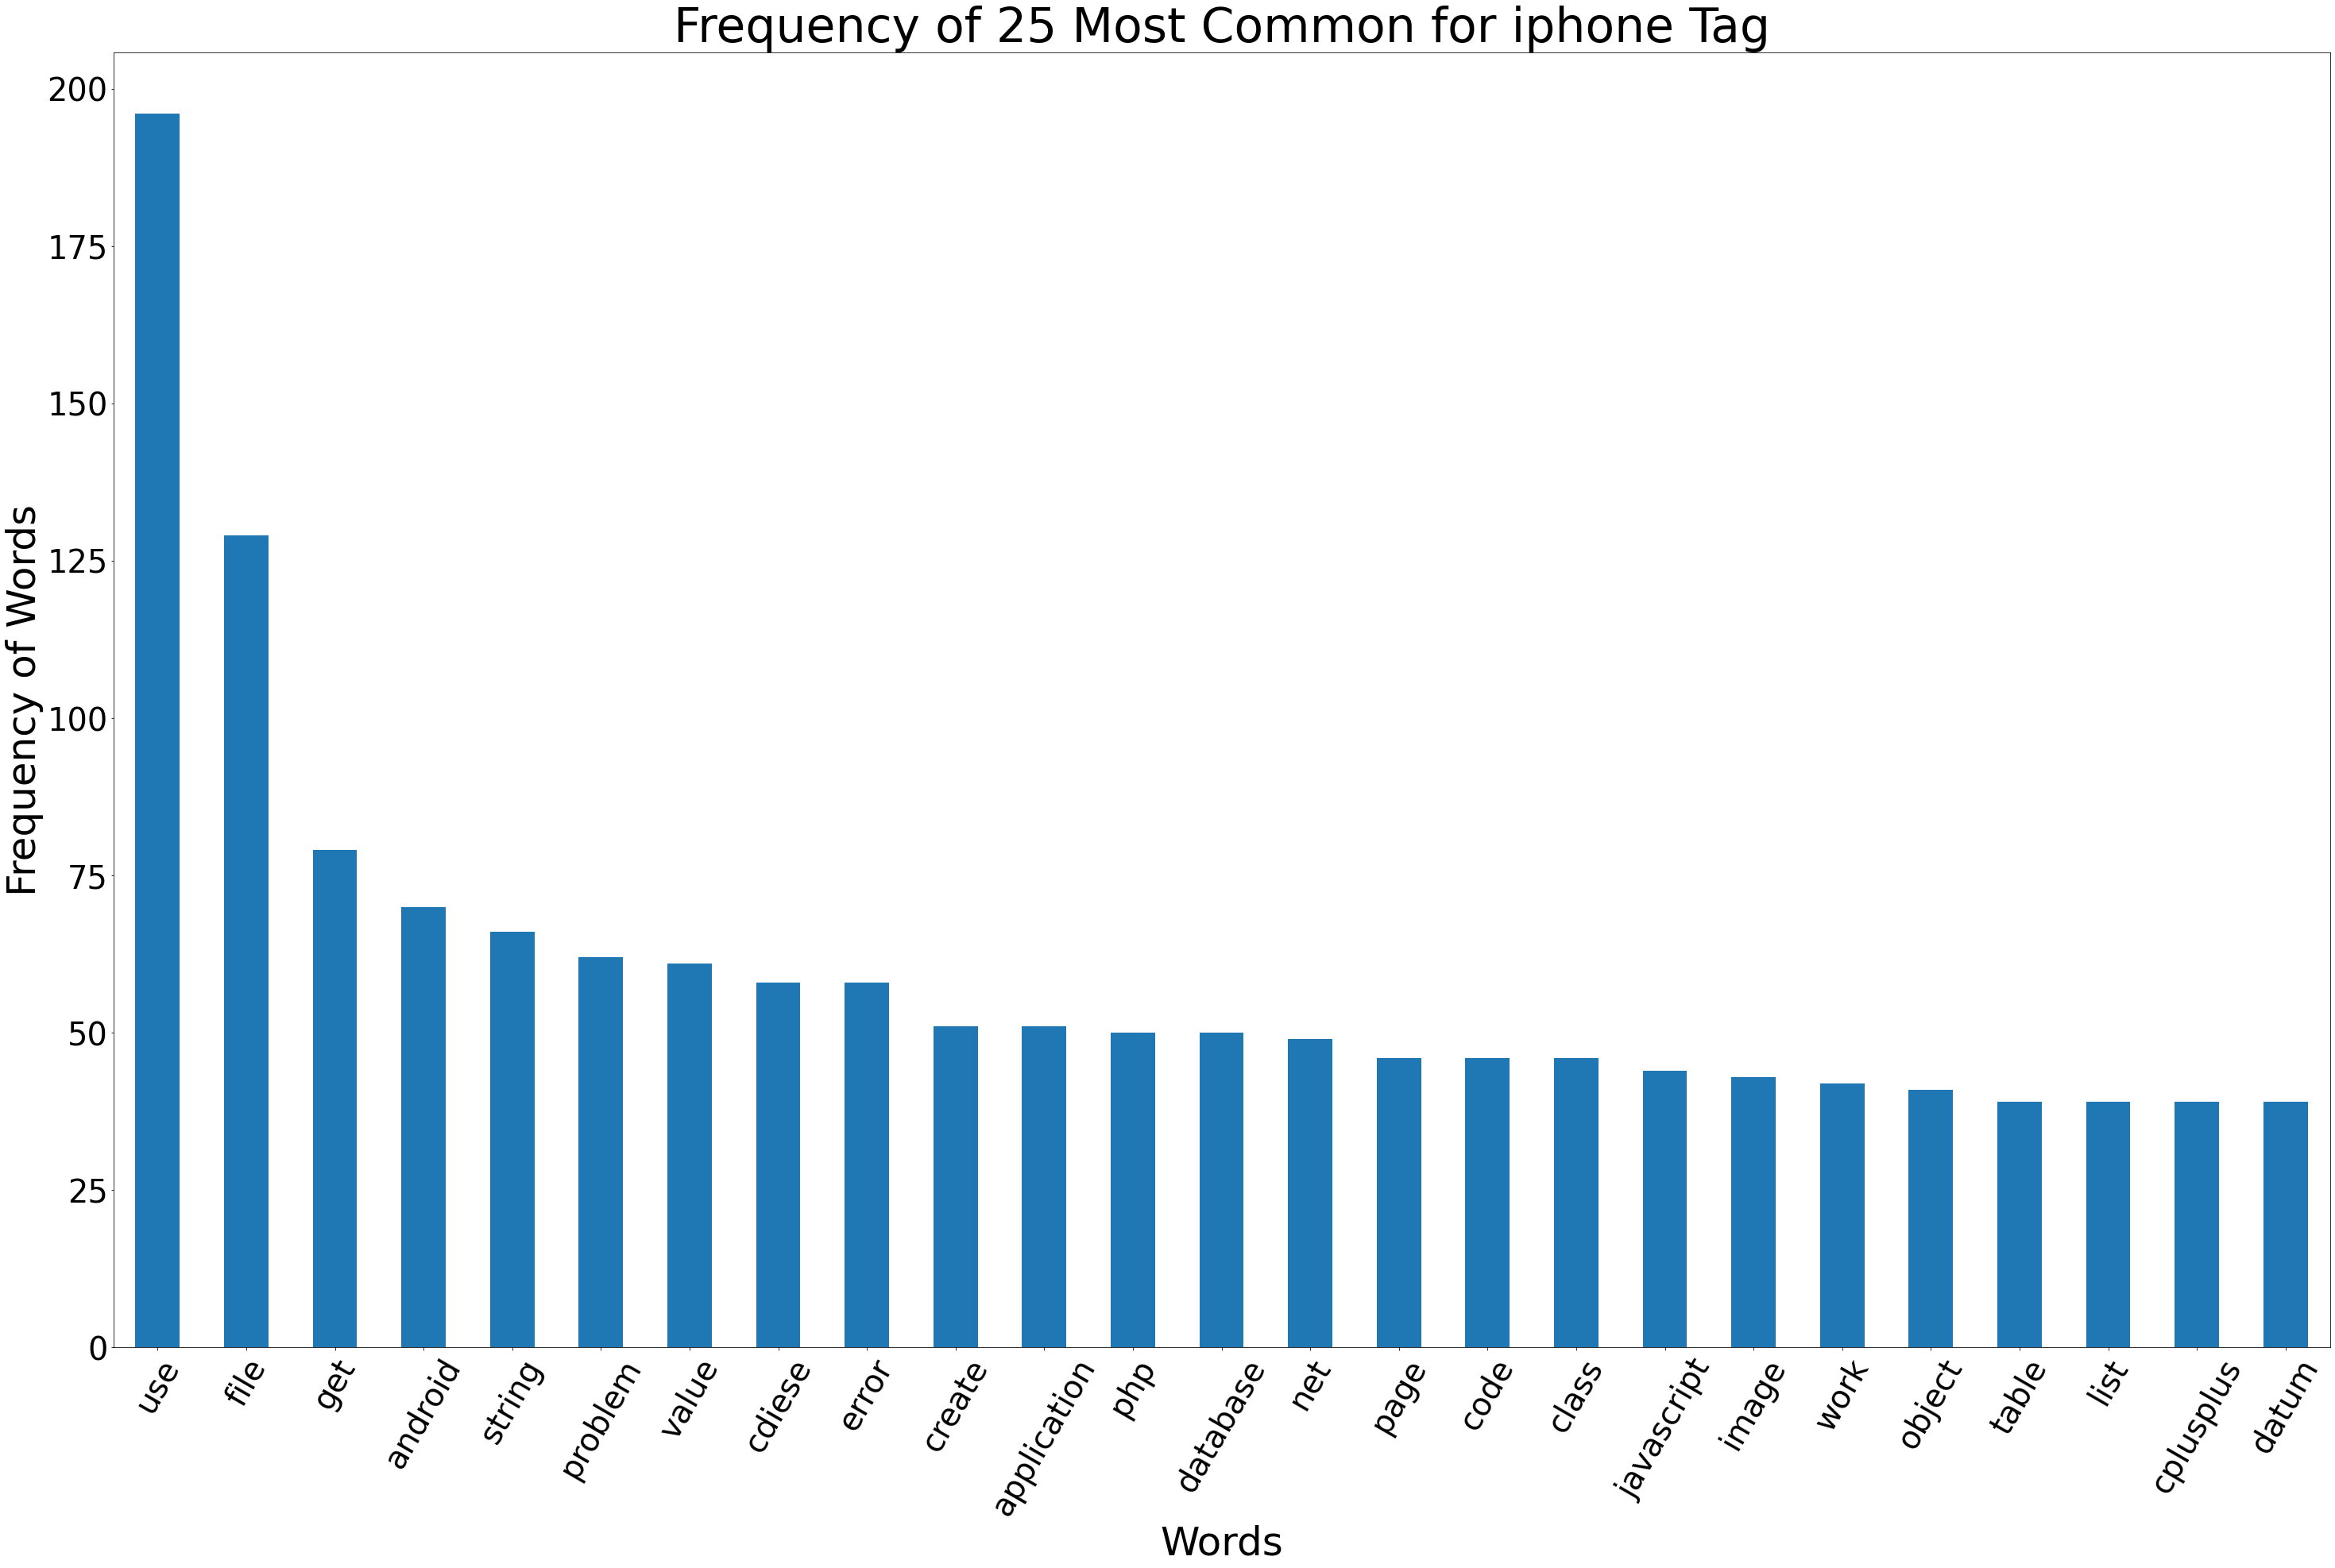

In [95]:
plt.figure(figsize=(50,30))

group_by = df.groupby('iphone')['Title'].apply(lambda x: collections.Counter(' '.join(x).split()))
group_by[0].sort_values(ascending=False).iloc[0:25].plot(kind='bar')      

plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common for iphone Tag', fontsize=60)
plt.show()

**<font color="green">Les Tags suggérés sont ils pertinents ? Il existes des méthodes de classification supervisées,non supervisées et une combinaison des deux,  pour comparer la pertinence des Tags. Cf notebook 2 </font>**

**Sources:**
    
Porter et Snowball Stemming:\
https://www.nltk.org/howto/stem.html
        